# Прогноз эффективности восстановления золота

# Описание проекта

## Краткое описание

Подготовить прототип модели машинного обучения.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

## Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

![](https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg)

1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.<br/>
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости)

2. Очистка
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

## Описание данных

Технологический процесс

+ `Rougher feed` — исходное сырье
+ `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
+ `Xanthate` **— ксантогенат (промотер, или активатор флотации);
+ `Sulphate` — сульфат (на данном производстве сульфид натрия);
+ `Depressant` — депрессант (силикат натрия).
+ `Rougher process` (англ. «грубый процесс») — флотация
+ `Rougher tails` — отвальные хвосты
+ `Float banks` — флотационная установка
+ `Cleaner process` — очистка
+ `Rougher Au` — черновой концентрат золота
+ `Final Au` — финальный концентрат золота

Параметры этапов

+ `air amount` — объём воздуха
+ `fluid levels` — уровень жидкости
+ `feed size` — размер гранул сырья
+ `feed rate` — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
+ `rougher` — флотация
+ `primary_cleaner` — первичная очистка
+ `secondary_cleaner` — вторичная очистка
+ `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
+ `input` — параметры сырья
+ `output` — параметры продукта
+ `state` — параметры, характеризующие текущее состояние этапа
+ `calculation` — расчётные характеристики

### Расчёт эффективности

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.<br/>
Эффективность обогащения рассчитывается по формуле:
![](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

где:
   + C — доля золота в концентрате после флотации/очистки;
   + F — доля золота в сырье/концентрате до флотации/очистки;
   + T — доля золота в отвальных хвостах после флотации/очистки.<br/>
   
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

### Метрика качества

В качестве метрики качества выберем sMAPE
![](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

Нужно спрогнозировать сразу две величины:<br/>
+ эффективность обогащения чернового концентрата `rougher.output.recovery`;
+ эффективность обогащения финального концентрата `final.output.recovery`.


Итоговая метрика складывается из двух величин:
![](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

# Общие данные

## Импортируем библиотеки

In [1]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# # для работы с датой
# import datetime
# from dateutil import relativedelta

# # Для работы со статистикой
from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly
# import plotly.graph_objs as go
# import plotly.express as px


#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
matplotlib.style.use('ggplot')

#для построения моделей
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV

#Для визуализации процесса
from tqdm.notebook import tqdm

## Загрузим данные

In [2]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'train': ('datasets/gold_recovery_train.csv', '.../datasets/gold_recovery_train.csv'),
    'test' : ('datasets/gold_recovery_test.csv', '.../datasets/gold_recovery_test.csv'),
    'full' : ('datasets/gold_recovery_full.csv',  '.../datasets/gold_recovery_full.csv')
}

def get_file(file_name, url):
    #Проверим есть ли файл
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        #качаем файл по ссылке url, кладем по пути file_name
        _ = urllib.request.urlretrieve(url, file_name)

[get_file(*urls[k]) for k in urls]
     
df_train = pd.read_csv(urls['train'][0], index_col='date')
df_test  = pd.read_csv(urls['test'] [0], index_col='date')
df_full  = pd.read_csv(urls['full'] [0], index_col='date')

## Используемые функции

In [3]:
def null_values_fraction(df):
    """
    Функция принимает дата фрейм
    Возвращает Series c долей пропусков по колонкам
    """
    df_null_fraction = ((df.isnull().sum() / len(df))\
        .sort_values(ascending=False)\
        .apply(lambda x: '{:0.2%}'.format(x)))
    print('первые 5 строк')
    print(df_null_fraction.head(),end='\n\n')
    print('последние 5 строк')
    print(df_null_fraction.tail())
    return df_null_fraction

In [4]:
def main_info_description(df):
    
    """
    Функция возвращает информацию о количестве дубликатов, типе данных, размере датасета и вызывает метод info()
    """
    
    _dupleсates = df.duplicated().sum()
    print('Количество дубликатов в датасете:')
    print(_dupleсates, end='\n\n')    
    
    _types = df.dtypes.value_counts().sort_values(ascending=False)
    print('Типы данных в датасете:')
    print(_types, end='\n\n')
    
    _shape = df.shape
    print('Размерность датасета:')
    print(_shape, end='\n\n')
    
    
    print('Основная информация:')
    print(df.info())

In [5]:
def hist_bulding(df):
    """
    Фукция возвращает гистограммы для всех колонок содержащих количественные данные 
    Также возвращает массив с перечнем колонок имеющих численное значение
    """
    bins = int(np.ceil(2 * (len(df) ** (1 / 3))))
    numeric_cols = df.describe().columns
    
    for i in range(0, len(numeric_cols), 9):
        if (i + 9) > (len(numeric_cols)):
            print('Колонки с {} по {}'.format(i, len(numeric_cols)))
            df[numeric_cols[i : len(numeric_cols)]].hist(bins=bins)
            plt.show()        
        else:
            print('Колонки с {} по {}'.format(i, (9 + i)))
            df[numeric_cols[i :(9 + i)]].hist(bins=bins)
            plt.show()
    return numeric_cols

In [6]:
def plot_stat_info(df, numeric_cols, diff_treshhold = .5):
    
    """
    Функция возвращает график с распределением среднего и квартилей
    Определяет наличие различий между медианой и средним в процентах
    в качестве границы различия принимает аргумент diff_treshhold=[0, 1], по умолчанию 0.5
    
    На вход принимает датасет с данными, список с количественными признаками
    """
    
    x = np.arange(0, len(numeric_cols))
    y_mean = df[numeric_cols].describe().loc['mean'].iloc[x]
    y_median = df[numeric_cols].describe().loc['50%'].iloc[x]
    y_q1 = df[numeric_cols].describe().loc['25%'].iloc[x]
    y_q2 = df[numeric_cols].describe().loc['75%'].iloc[x]

    fig, ax = plt.subplots()
    ax.grid(which='major',
            color = 'k')
    ax.minorticks_on()

    ax.grid(which='minor',
            color = 'gray',
            linestyle = '-')

    ax.plot(x, y_mean, color = 'r', linewidth = 1)
    ax.plot(x, y_median, color = 'b', linewidth = 1)
    ax.plot(x, y_q1, color = 'g', linewidth = 1)
    ax.plot(x, y_q2, color = 'y', linewidth = 1)
    
    plt.title('Значение статистических параметров по признакам')
    plt.xlabel('Порядковый номер признака')
    plt.ylabel('Значение параметра')
    plt.legend(labels=['mean', 'median', 'Q1', 'Q3'])

    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()
    
    treshhold_cols=[]
    
    for col in numeric_cols:
        ratio = 1 - (df[col].median() / df[col].mean())
        if (ratio > diff_treshhold) | (ratio < -diff_treshhold):
            print('Значительное различие между медианой и средним в колонке "{}"\nРазница составляет {:.0%}, возможны выбросы'\
                  .format(col, ratio), end='\n\n')
            treshhold_cols.append(col)
            
    if len(treshhold_cols) == 0:
        print('Значительных отклонений не обнаружено')
    
    return treshhold_cols

In [7]:
def find_features(df, features):
    """
    Функция возвращает перечень названий колонок содержащих features
    """
    cols = []
    for elem in df.columns:
        if features in elem:
            cols.append(elem)
    if len(cols) == 0:
        print('Колонок содержащих "{}" не найдено'.format(features))
    return cols

In [8]:
def sMAPE_compute(y_true, y_pred):
    
    """
    Функция расчитывает и возвращает значение sMAPE
    """
    total = 0
    for i in range(len(y_true)):
        total += abs(y_true.iloc[i] - y_pred[i]) / ((abs(y_true.iloc[i]) + abs(y_pred[i])) / 2)
    sMAPE = total / len(y_true) * 100
    return sMAPE

In [9]:
def recovery_compute(df, c, f, t):
    
    """
    Функция возвращает Series с расчитанной величиной эффективности обогащения
    по формуле C * (F - T) / (F * (C - T)) * 100
    
    принимает датасет содержащий:
    c - доля золота в концентрате после флотации/очистки
    f - доля золота в сырье/концентрате до флотации/очистки
    t - доля золота в отвальных хвостах после флотации/очистки
    """
    
    C = df[c]
    F = df[f]
    T = df[t]
    
    recovery = C * (F - T) / (F * (C - T)) * 100
    return recovery

In [10]:
def cols_feat_importances(model, X, y):
    
    """
    Функция возвращает наиболее 2-таблицы:
    df_feat - отсортированная таблица наиболе важных признаков
    df_feat_result - результаты абсолютных ошибок при уменьшении количества признаков начиная с наименее важных
    """
    #Разделим полученую выборку для оценки модели и обучим модель
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size=.25,
                                                      random_state=42
                                                      )
    
    model.fit(X_train, y_train)
    
    #Составим таблицу с указанием важности признака
    df_feat = pd.DataFrame(data=model.feature_importances_,
                          index=X_train.columns,
                          columns=['feature_importances'])\
                    .sort_values(by='feature_importances', ascending=False)
    
    
    feat_impot_dict = {
        'число_признаков' : [],
        'MAE' : [],
        'sMAPE' : []
    }

    min_sMAPE = 100
    impotantce_treshhold = 0
    
    # Убираем по одному признаку и проверяем качество модели
    for i in tqdm(range(len(df_feat), 0, -1)):
        new_feat = df_feat\
                    .iloc[:i]\
                    .index\
                    .values

        model.fit(X_train[new_feat], y_train)
        pred = model.predict(X_val[new_feat])

        MAE = mean_absolute_error(y_val, pred)
        sMAPE = sMAPE_compute(y_val, pred)

        feat_impot_dict['число_признаков'].append(len(new_feat))
        feat_impot_dict['MAE'].append(MAE)
        feat_impot_dict['sMAPE'].append(sMAPE)

        if sMAPE < min_sMAPE:
            impotantce_treshhold = i
            min_sMAPE = sMAPE
            min_MAE = MAE

    print('Лучший результат при {} признаках, MAE = {:0.5f}, sMAPE = {:0.5f}'.format(impotantce_treshhold,
                                                                                    min_MAE,
                                                                                    min_sMAPE))
    df_feat_result = pd.DataFrame(feat_impot_dict)
    df_feat_result = df_feat_result.set_index('число_признаков')
    
    return df_feat, df_feat_result

In [11]:
def sMAPE_sanity_check(y_target, y_train):
    
    """
    Функция производит проверку на вменяемость модели
    """
    sanit_chek = pd.Series([y_train.mean() for i in range(len(y_target))])
    
    return sMAPE_compute(y_target, sanit_chek)

In [12]:
def standardization_sampels(X_train, X_test, numeric_cols):
    
    """
    Функция принимает X_train - для которого будет производиться с стандатризаиция
    и X_test - для которго нужно выполнить стандартизацию на основе X_train
    
    Возвращает нормированные таблицы
    """
    
    scaler = StandardScaler()
    scaler.fit(X_train[numeric_cols])

    X_train_stand = pd.DataFrame(scaler.transform(X_train[numeric_cols]), columns=numeric_cols,
                 index=X_train.index)

    X_test_stand = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns=numeric_cols,
                 index=X_test.index)
    
    return X_train_stand, X_test_stand

# 1. Подготовка данных

## 1.1. Откроем и изучим данные

Проведем анализ основно информации из датасетов

### 1.1.1 df_train

In [13]:
df_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [14]:
main_info_description(df_train)

Количество дубликатов в датасете:
16

Типы данных в датасете:
float64    86
dtype: int64

Размерность датасета:
(16860, 86)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sul

In [15]:
data_train_null_values = null_values_fraction(df_train)

первые 5 строк
rougher.output.recovery              15.26%
rougher.output.tail_ag               13.35%
rougher.output.tail_sol              13.34%
rougher.output.tail_au               13.34%
secondary_cleaner.output.tail_sol    11.78%
dtype: object

последние 5 строк
rougher.calculation.floatbank10_sulfate_to_au_feed    0.16%
rougher.calculation.sulfate_to_au_concentrate         0.16%
primary_cleaner.state.floatbank8_d_level              0.16%
primary_cleaner.state.floatbank8_c_level              0.16%
primary_cleaner.input.feed_size                       0.00%
dtype: object


Колонки с 0 по 9


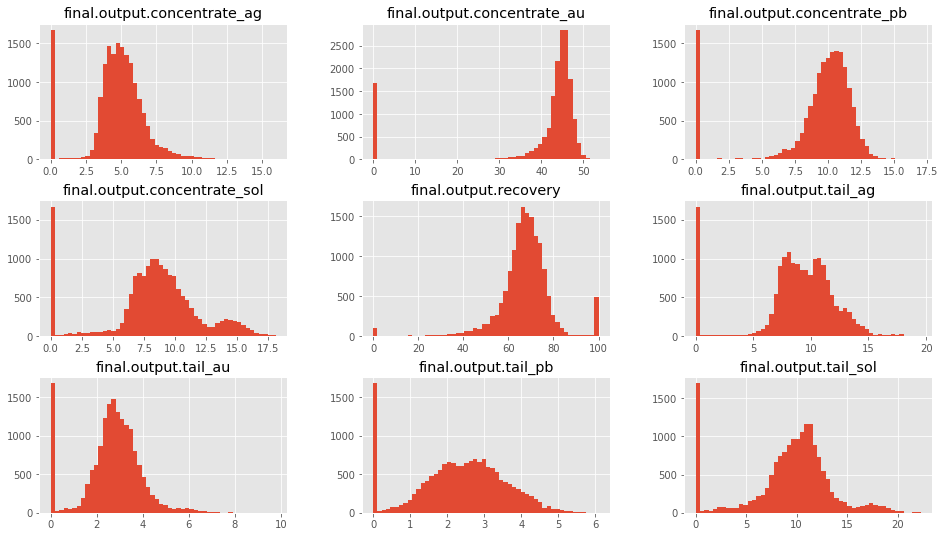

Колонки с 9 по 18


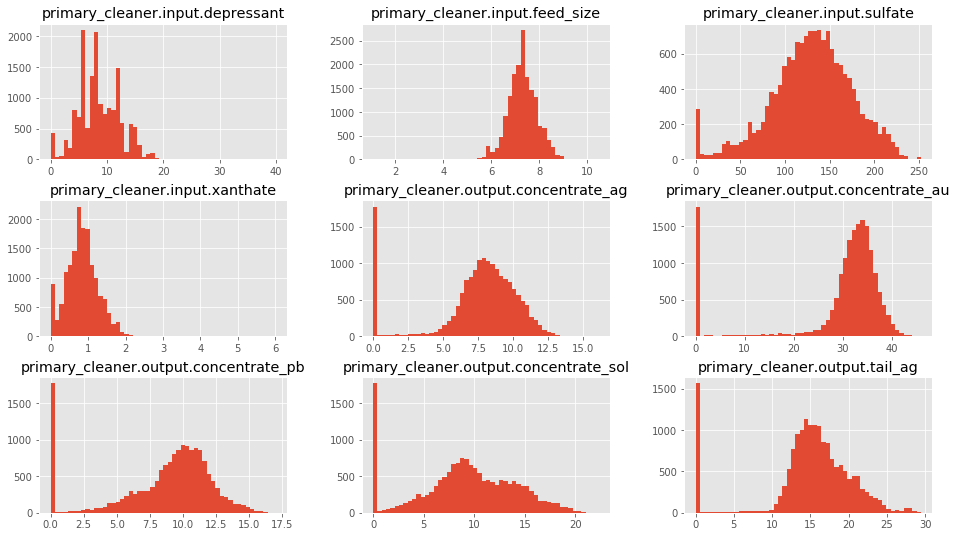

Колонки с 18 по 27


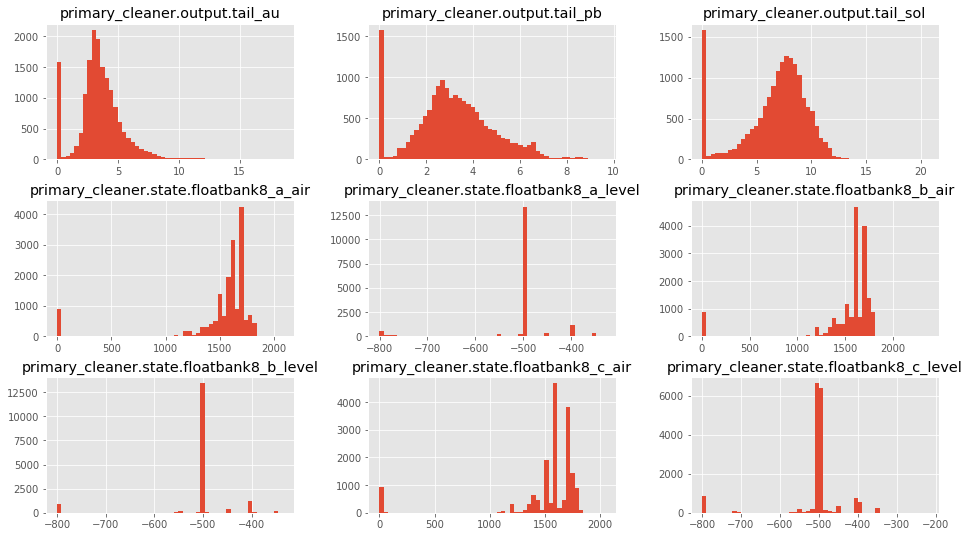

Колонки с 27 по 36


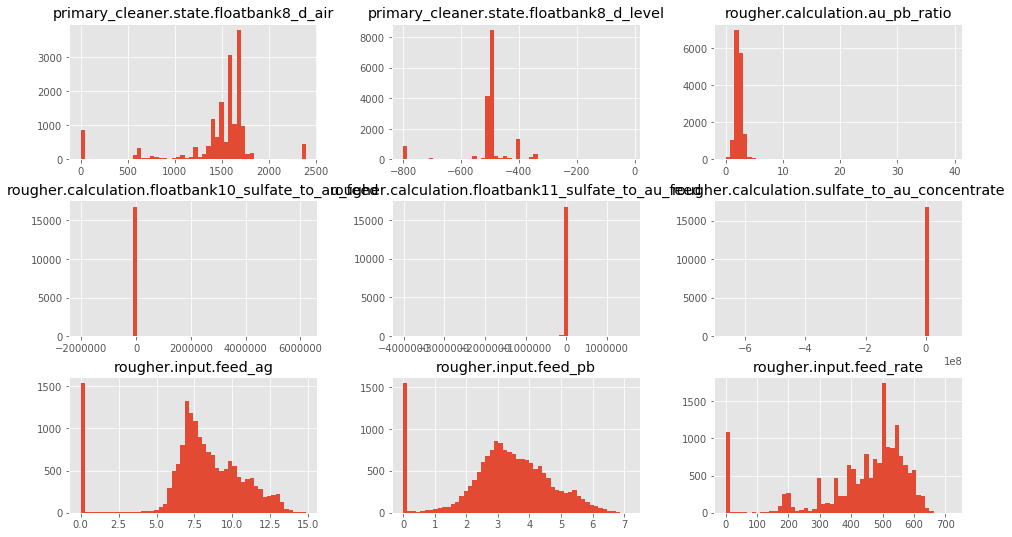

Колонки с 36 по 45


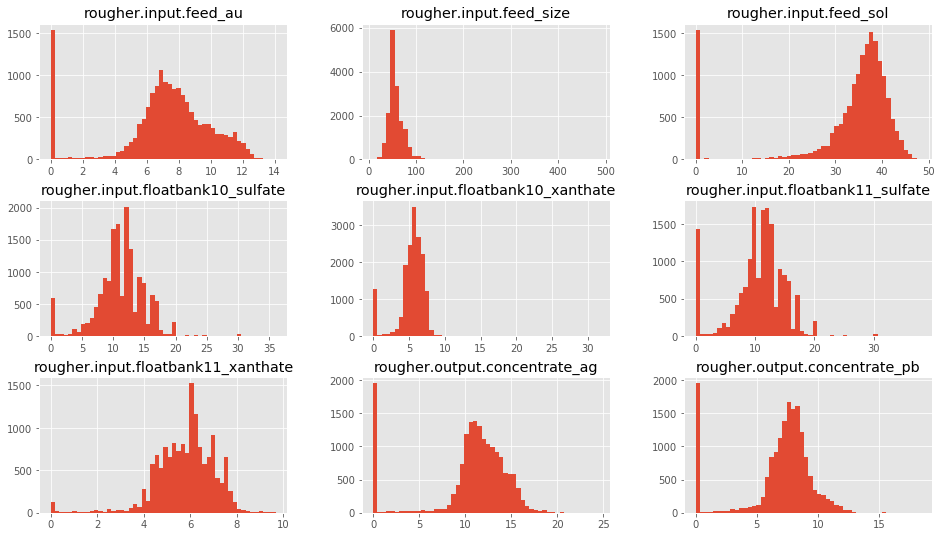

Колонки с 45 по 54


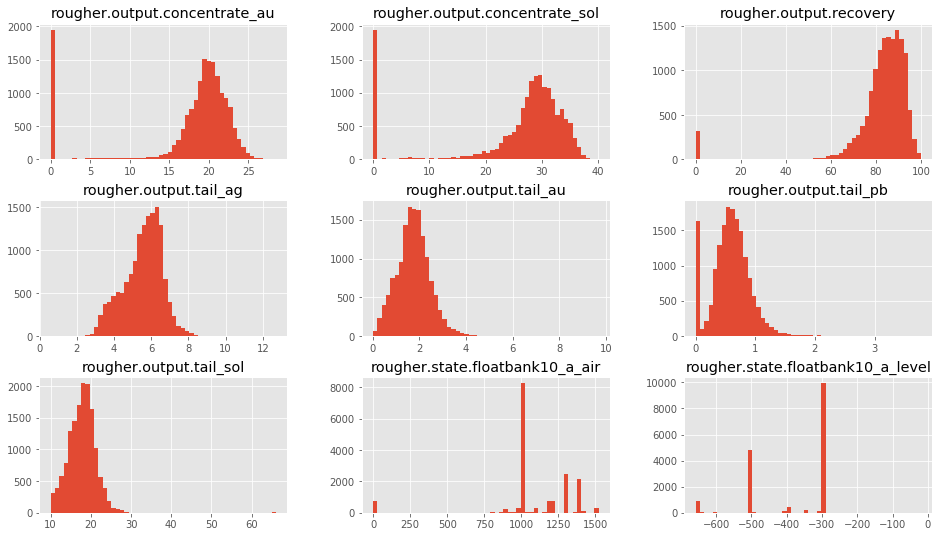

Колонки с 54 по 63


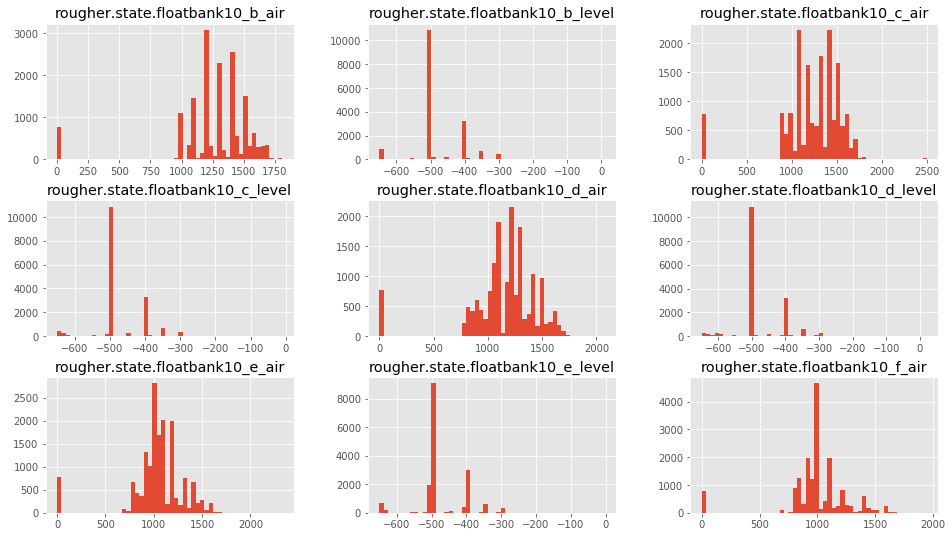

Колонки с 63 по 72


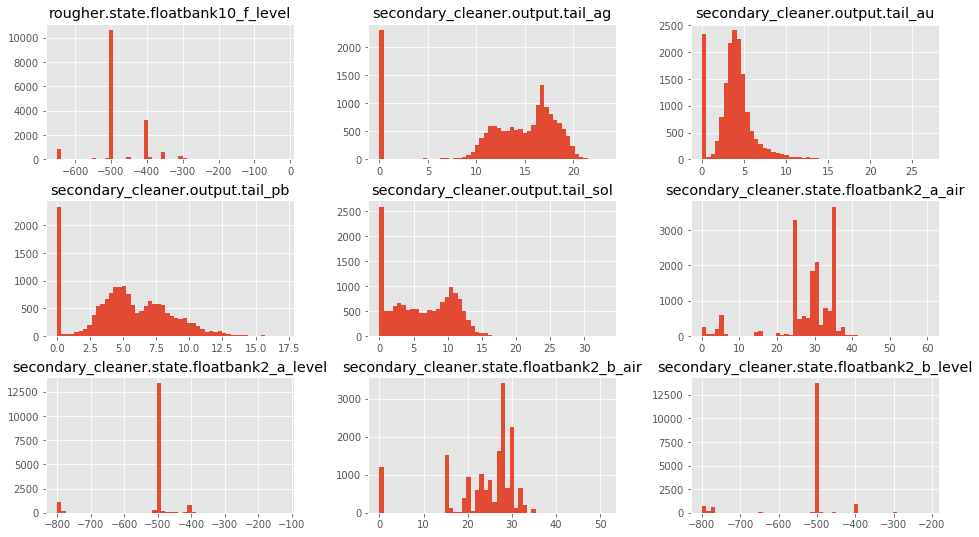

Колонки с 72 по 81


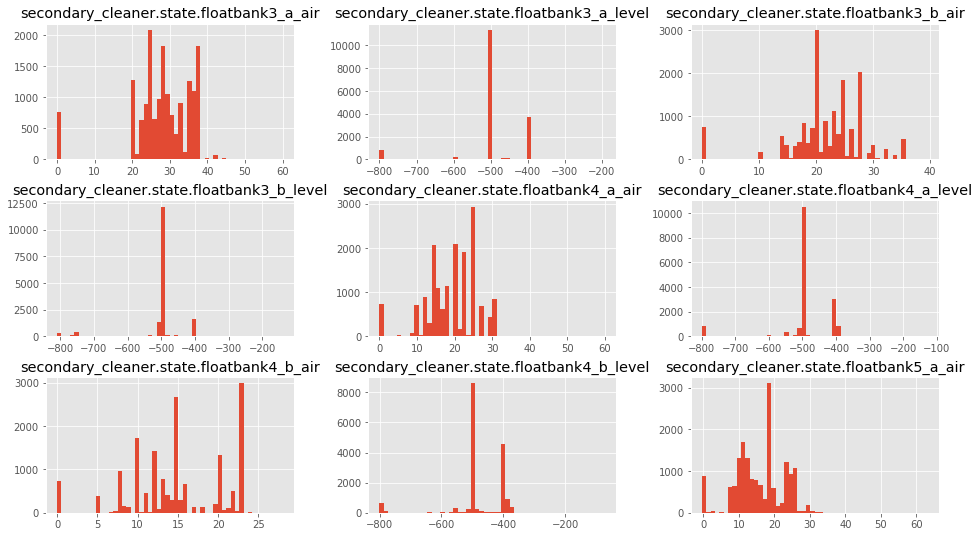

Колонки с 81 по 86


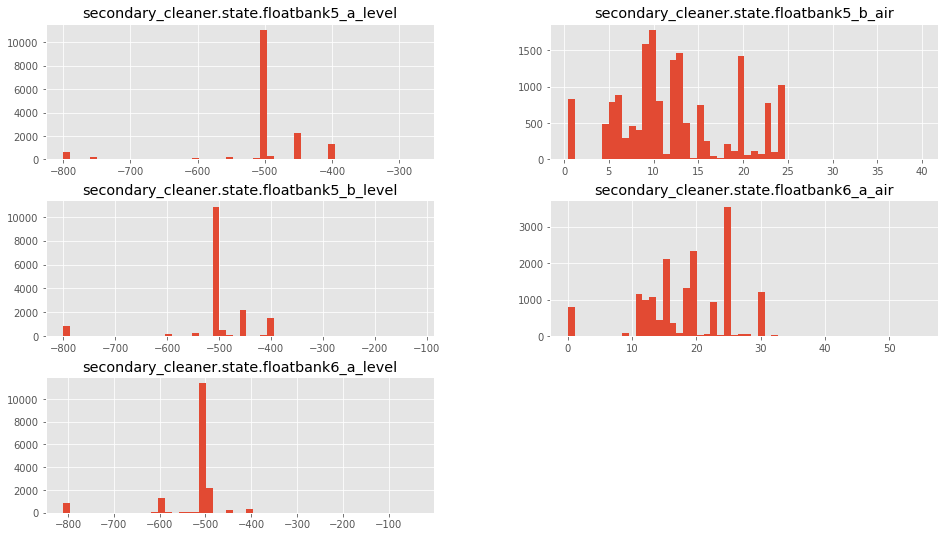

In [16]:
df_train_numeric_cols = hist_bulding(df_train)

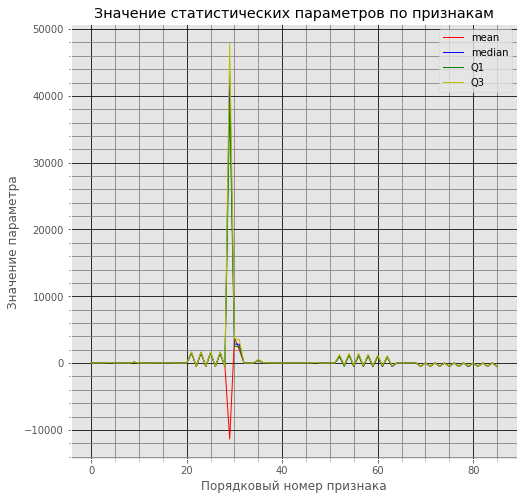

Значительное различие между медианой и средним в колонке "rougher.calculation.sulfate_to_au_concentrate"
Разница составляет 480%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank10_sulfate_to_au_feed"
Разница составляет 25%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank11_sulfate_to_au_feed"
Разница составляет -40%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.state.floatbank10_a_level"
Разница составляет 22%, возможны выбросы



In [17]:
#проверено для diff_treshhold = 0.1 ... 0.2 наибольший "мусор" при 0.2
_tresh = plot_stat_info(df_train, df_train_numeric_cols, diff_treshhold=0.2)

In [18]:
df_train[_tresh].describe()

,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.state.floatbank10_a_level
count,1.683300e+04,1.683300e+04,1.683300e+04,16807.000000
mean,-1.137202e+04,3.784836e+03,2.017512e+03,-384.109359
std,5.754320e+06,7.088720e+04,4.836941e+04,112.408685
min,-6.643891e+08,-2.023459e+06,-4.014502e+06,-658.223080
25%,3.898865e+04,2.502308e+03,2.498158e+03,-499.908427
50%,4.316793e+04,2.854641e+03,2.815062e+03,-300.233403
75%,4.781106e+04,3.644408e+03,3.511394e+03,-299.976784
max,8.332404e+07,6.211433e+06,1.537564e+06,-19.383282


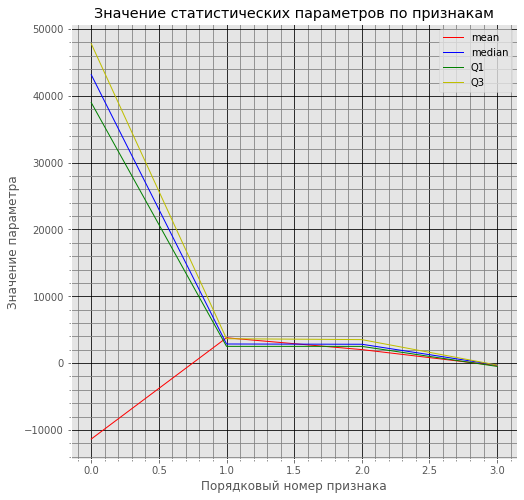

Значительное различие между медианой и средним в колонке "rougher.calculation.sulfate_to_au_concentrate"
Разница составляет 480%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank10_sulfate_to_au_feed"
Разница составляет 25%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank11_sulfate_to_au_feed"
Разница составляет -40%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.state.floatbank10_a_level"
Разница составляет 22%, возможны выбросы



In [19]:
_ = plot_stat_info(df_train, _tresh, diff_treshhold=0.2)

Колонки с 0 по 4


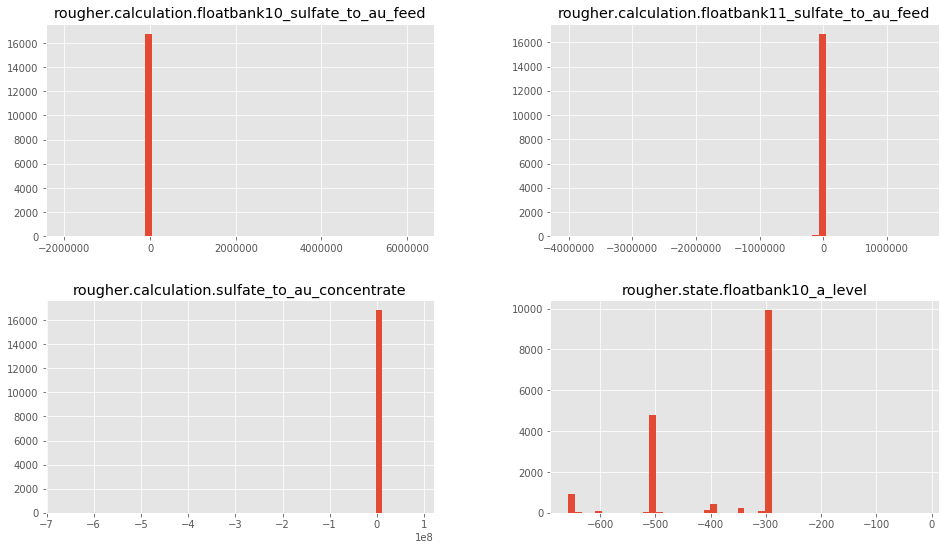

In [20]:
_ = hist_bulding(df_train[_])

### Вывод

1. В `df_train` наблюдается пропущенные значения в 84 из 86 колонках, с количеством пропусков от 0,16% до 15,26%
2. Из гистограмм наблюдается:
    + большое количество нулевых значений по отдельным признакам
    + отдельные признаки практически не меняются
    + для отдельных признаков наблюдаются выбросы
3. Определены колонки с отклонениями между медианой и средним больше 20%, построены дистограммы для этих признаков, делая вывод из распределения на гистограммах можно заметить, что величины практически не меняются в наблюдениях, возможно в дальнейшем можно удалить эти признаки из модели (проверим далее в проекте)
4. Имеются объекты, определенные как дубликаты, необходимо проверить

### 1.1.2 df_test

In [21]:
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [22]:
main_info_description(df_test)

Количество дубликатов в датасете:
6

Типы данных в датасете:
float64    52
dtype: int64

Размерность датасета:
(5856, 52)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air   

In [23]:
data_test_null_values = null_values_fraction(df_test)

первые 5 строк
rougher.input.floatbank11_xanthate    6.03%
primary_cleaner.input.sulfate         5.16%
primary_cleaner.input.depressant      4.85%
rougher.input.floatbank10_sulfate     4.39%
primary_cleaner.input.xanthate        2.83%
dtype: object

последние 5 строк
rougher.state.floatbank10_e_level    0.27%
rougher.state.floatbank10_d_level    0.27%
rougher.state.floatbank10_c_level    0.27%
rougher.state.floatbank10_b_level    0.27%
primary_cleaner.input.feed_size      0.00%
dtype: object


Колонки с 0 по 9


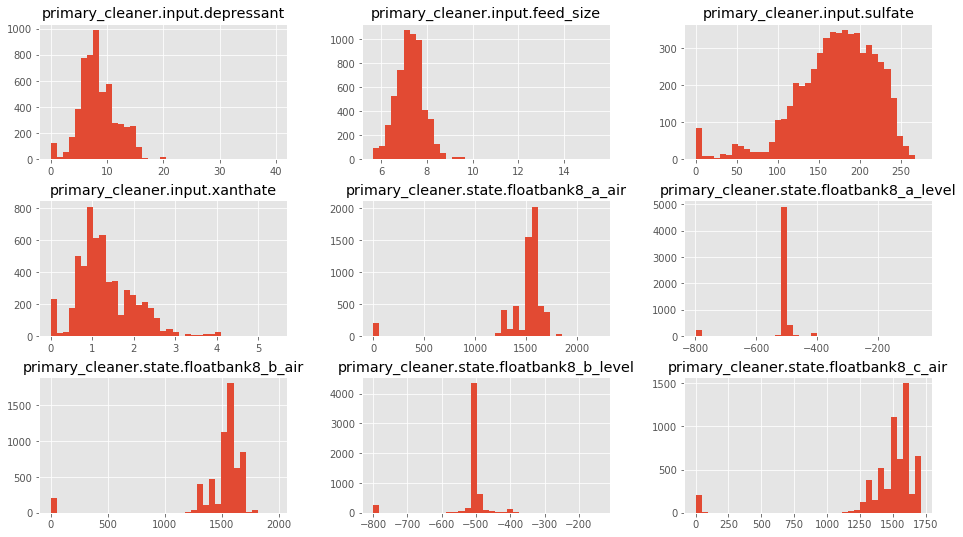

Колонки с 9 по 18


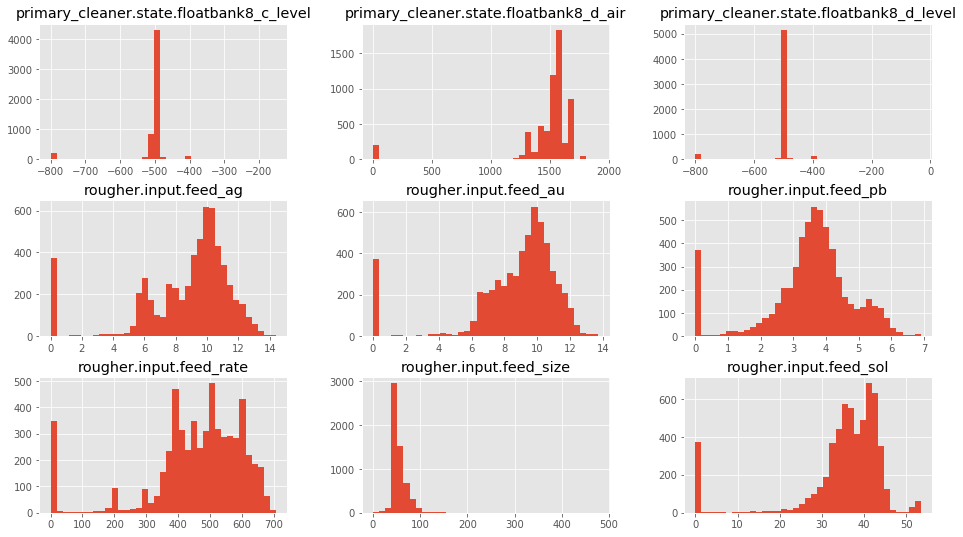

Колонки с 18 по 27


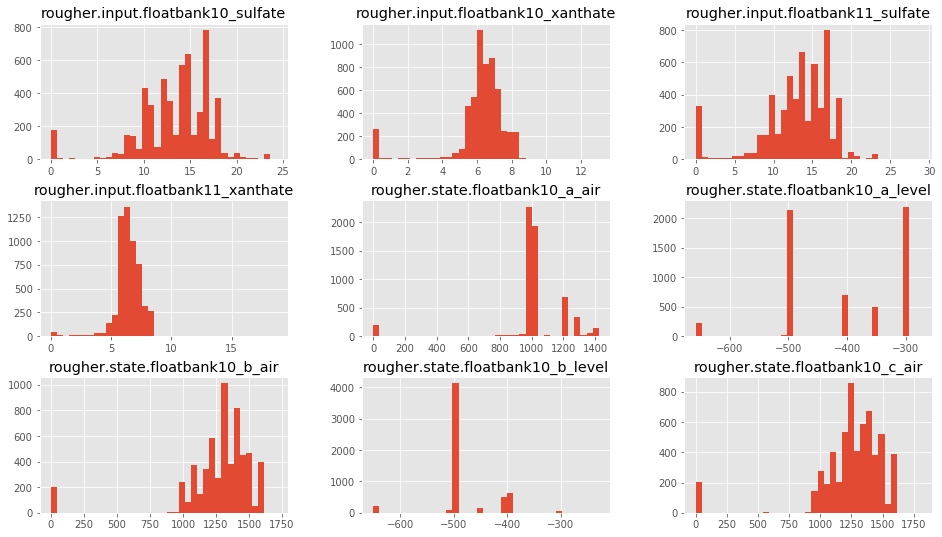

Колонки с 27 по 36


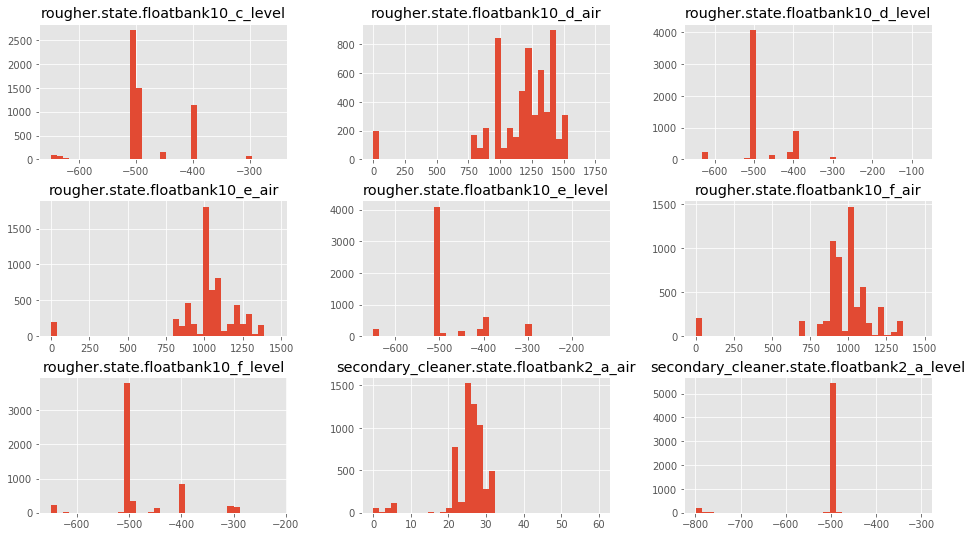

Колонки с 36 по 45


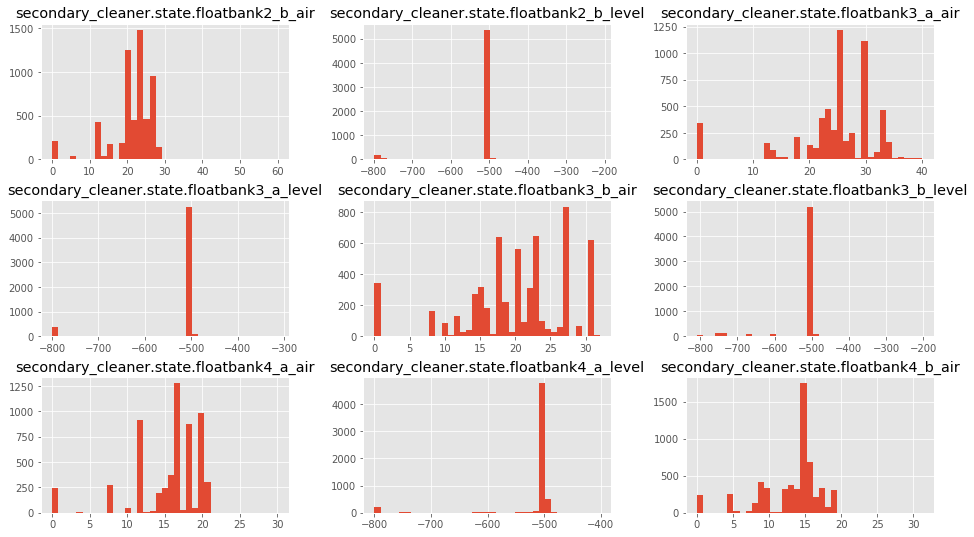

Колонки с 45 по 52


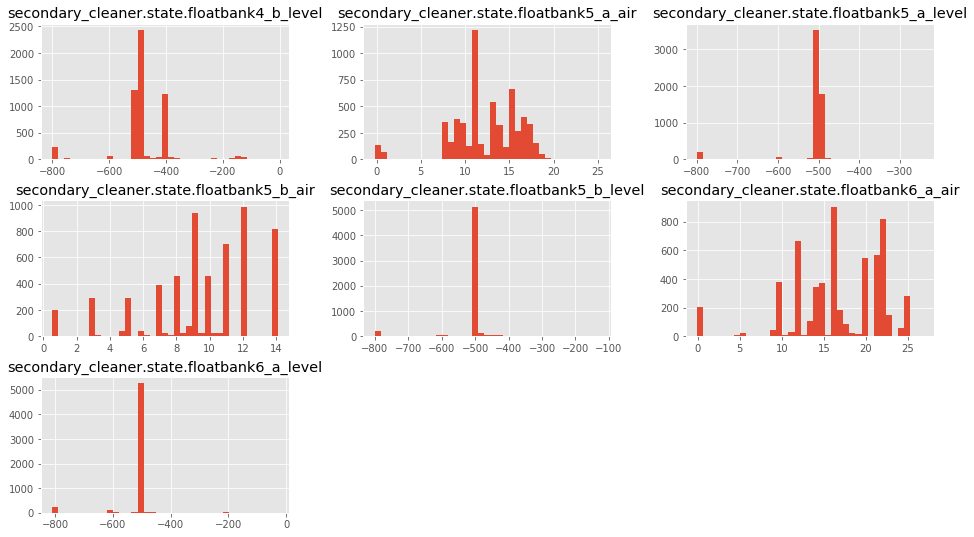

In [24]:
df_test_numeric_cols = hist_bulding(df_test)

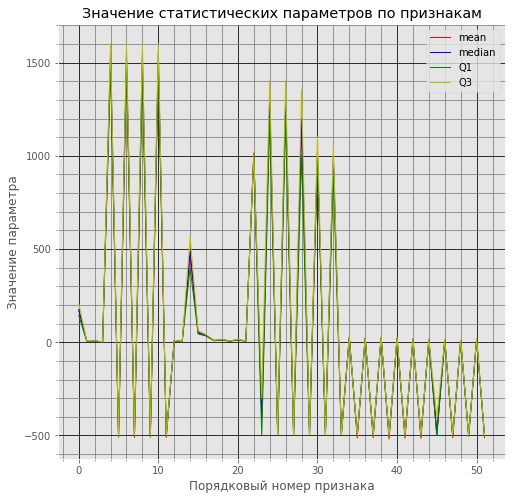

Значительное различие между медианой и средним в колонке "primary_cleaner.input.xanthate"
Разница составляет 10%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.input.feed_ag"
Разница составляет -10%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.input.feed_size"
Разница составляет 11%, возможны выбросы

Значительное различие между медианой и средним в колонке "secondary_cleaner.state.floatbank4_b_air"
Разница составляет -14%, возможны выбросы



In [25]:
_tresh = plot_stat_info(df_test, df_test_numeric_cols, diff_treshhold=.1)

Колонки с 0 по 4


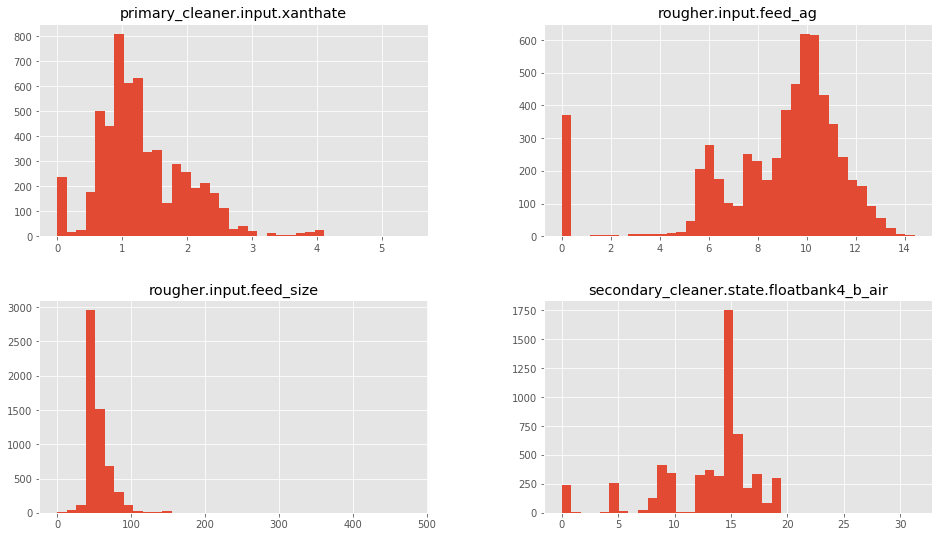

In [26]:
_ = hist_bulding(df_test[_tresh])

### Вывод

1. В `df_test` наблюдается пропущенные значения в 51 из 52 колонках, с количеством пропусков от 0,27% до 6,03%
2. Из гистограмм наблюдается:
    + большое количество нулевых значений по отдельным признакам
    + отдельные признаки практически не меняются
    + для отдельных признаков наблюдаются выбросы
3. Также найдены признаки с отклонением между средним и медианой, но по их гистограммам однозначных выводов сделать нельзя
4. Имеются объекты, определенные как дубликаты, необходимо проверить
5. Часть признаков отсутствует

### 1.1.3 df_full

In [27]:
df_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [28]:
main_info_description(df_full)

Количество дубликатов в датасете:
22

Типы данных в датасете:
float64    86
dtype: int64

Размерность датасета:
(22716, 86)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sul

In [29]:
data_full_null_values = null_values_fraction(df_full)

первые 5 строк
rougher.output.recovery               13.73%
rougher.output.tail_ag                12.05%
rougher.output.tail_sol               12.04%
rougher.output.tail_au                12.04%
rougher.input.floatbank11_xanthate     9.94%
dtype: object

последние 5 строк
rougher.calculation.sulfate_to_au_concentrate    0.19%
primary_cleaner.state.floatbank8_d_level         0.19%
primary_cleaner.state.floatbank8_b_level         0.19%
primary_cleaner.state.floatbank8_c_level         0.19%
primary_cleaner.input.feed_size                  0.00%
dtype: object


Колонки с 0 по 9


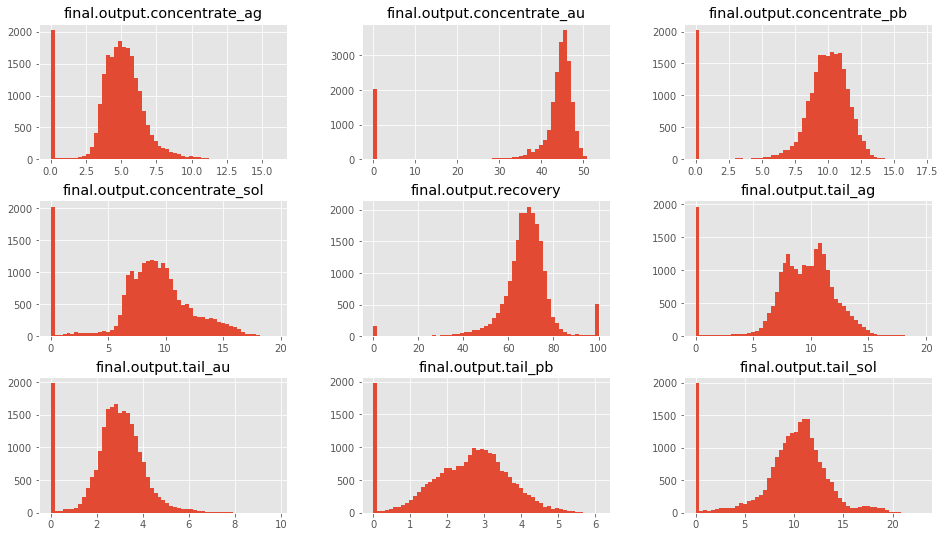

Колонки с 9 по 18


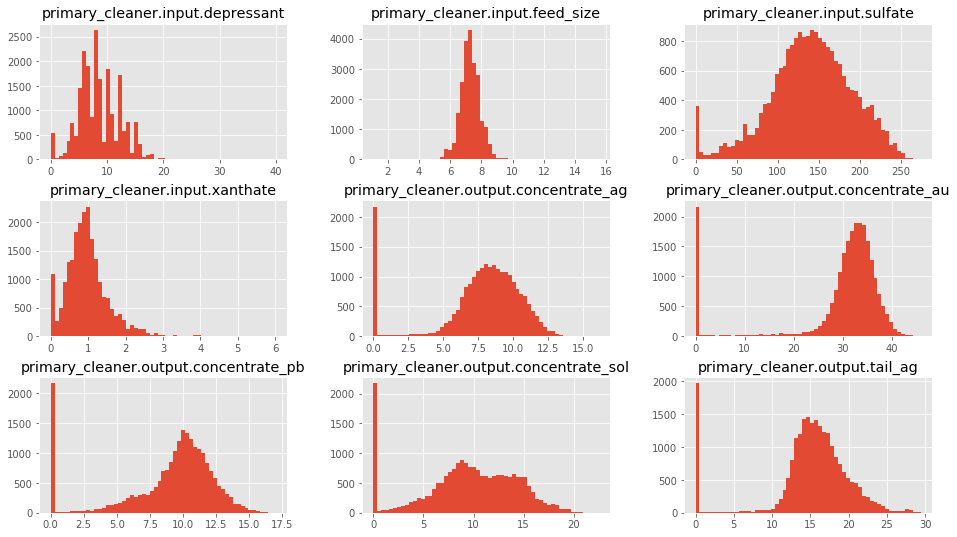

Колонки с 18 по 27


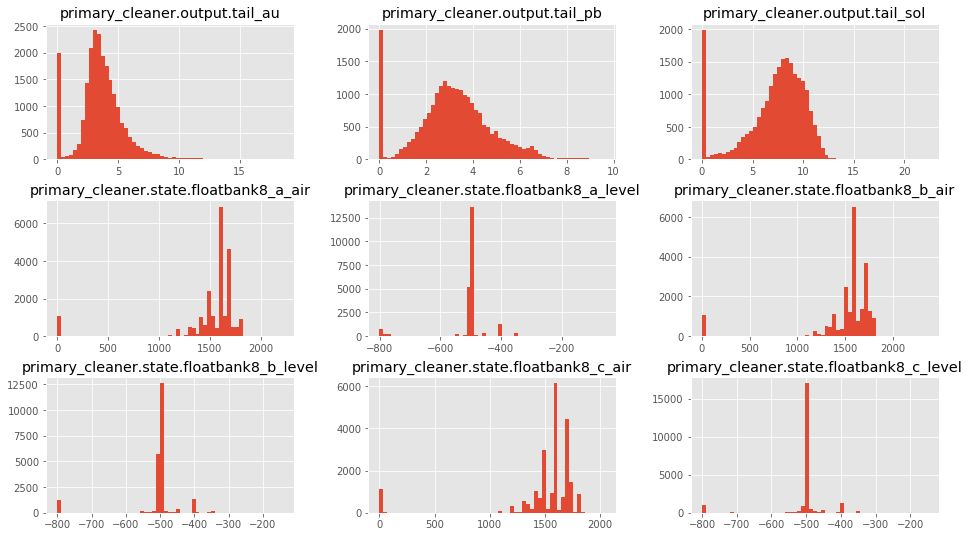

Колонки с 27 по 36


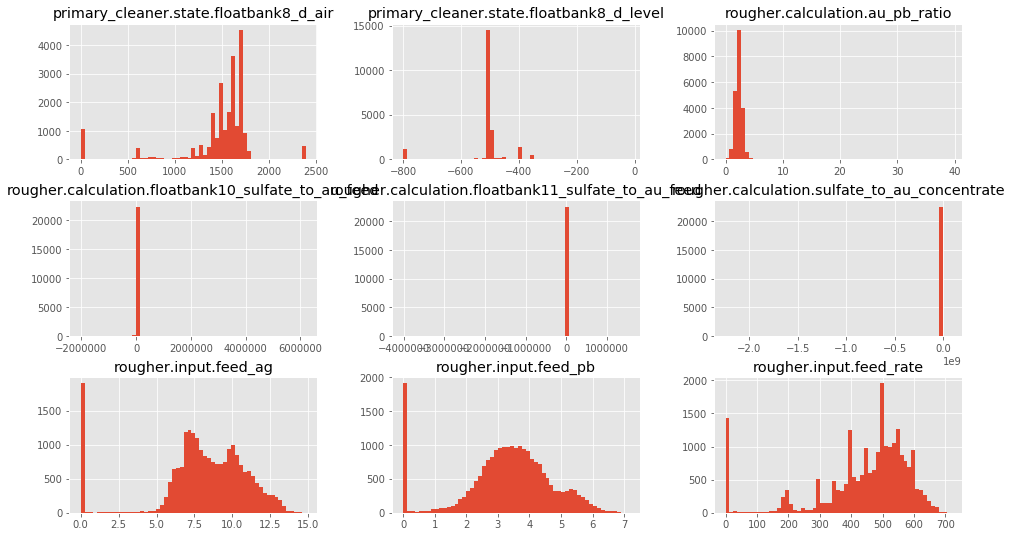

Колонки с 36 по 45


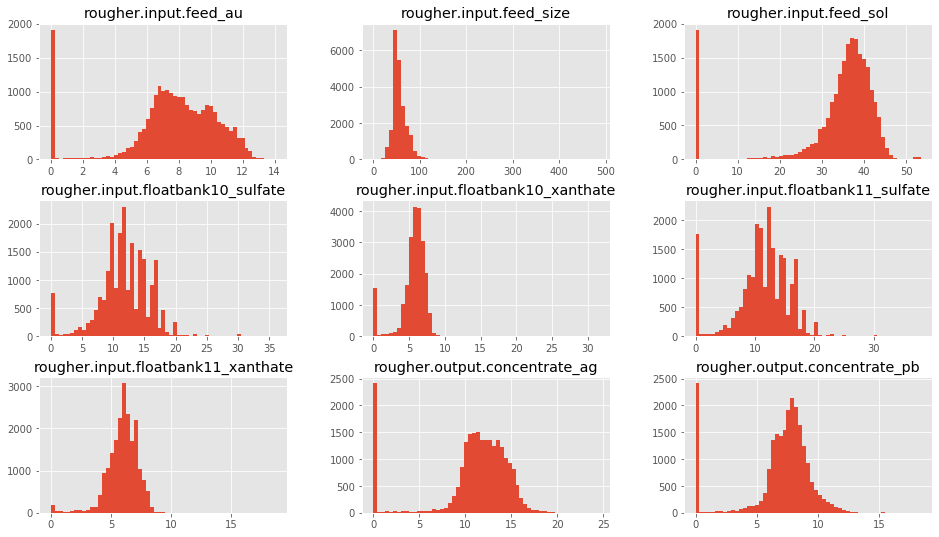

Колонки с 45 по 54


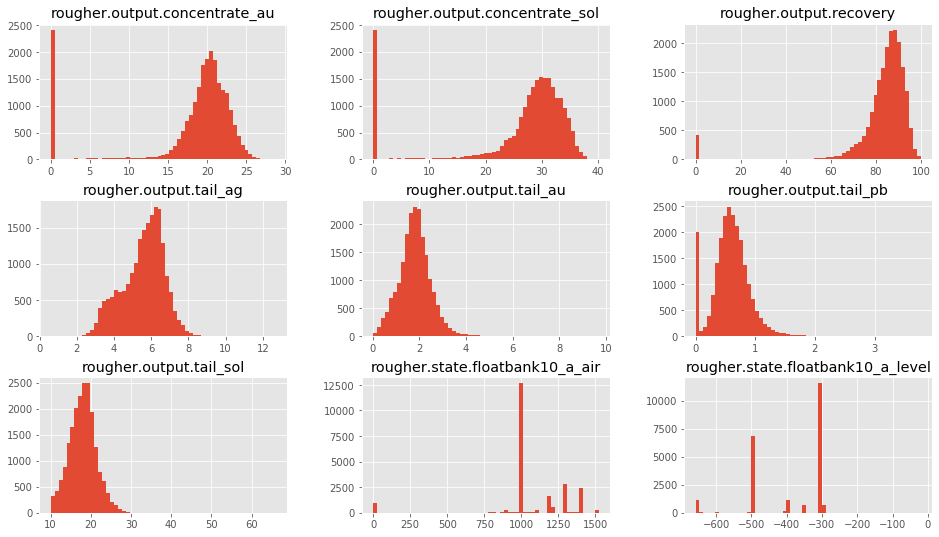

Колонки с 54 по 63


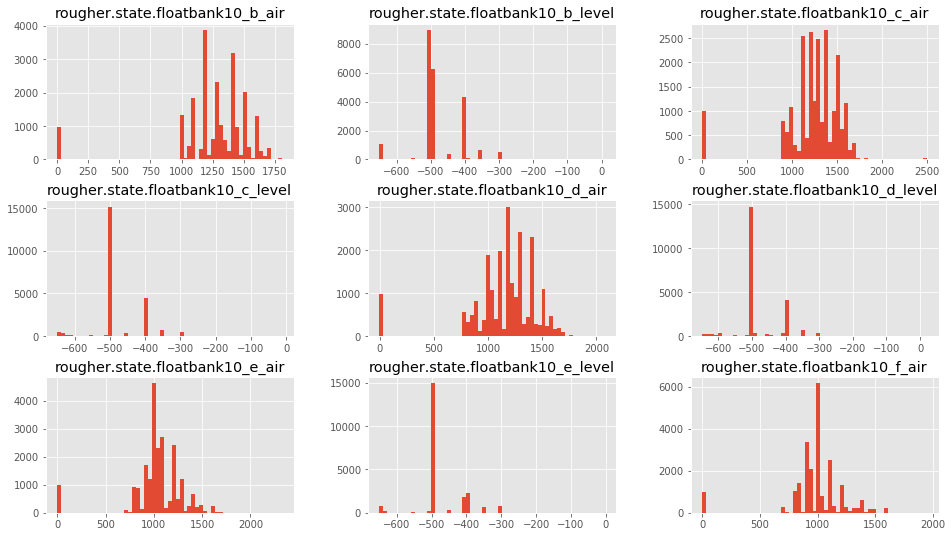

Колонки с 63 по 72


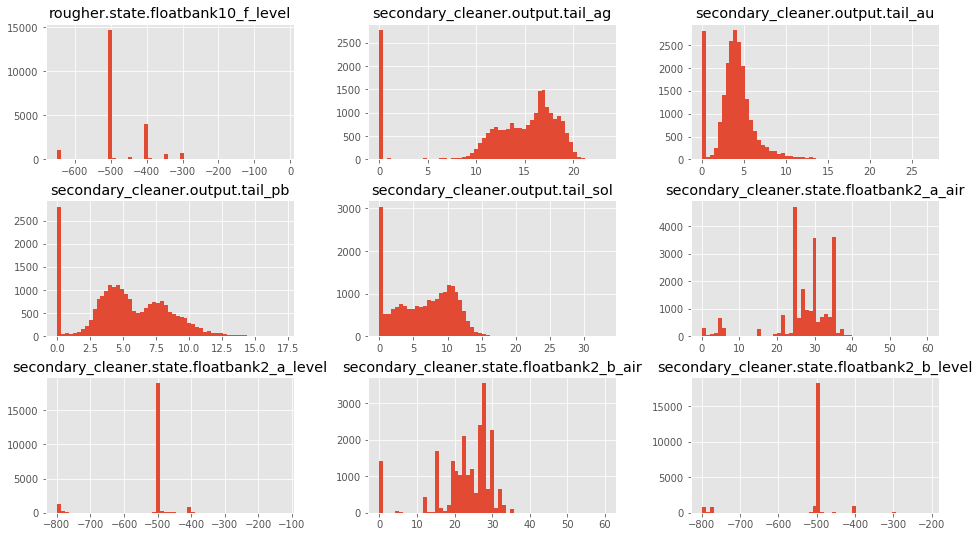

Колонки с 72 по 81


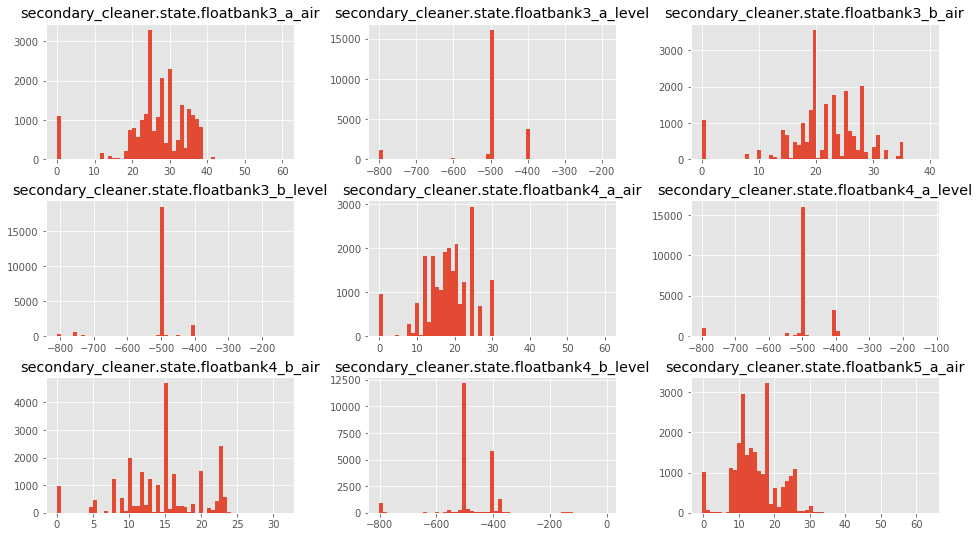

Колонки с 81 по 86


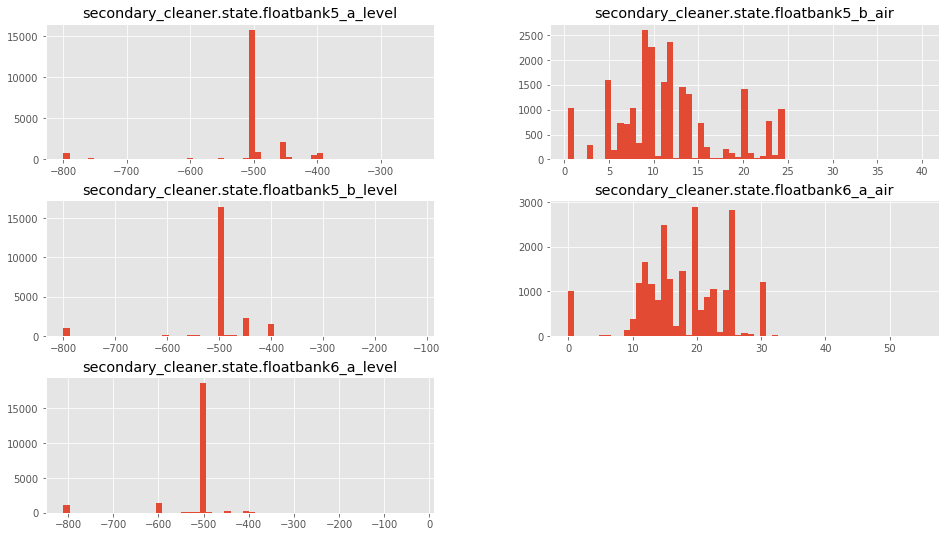

In [30]:
df_full_numeric_cols = hist_bulding(df_full)

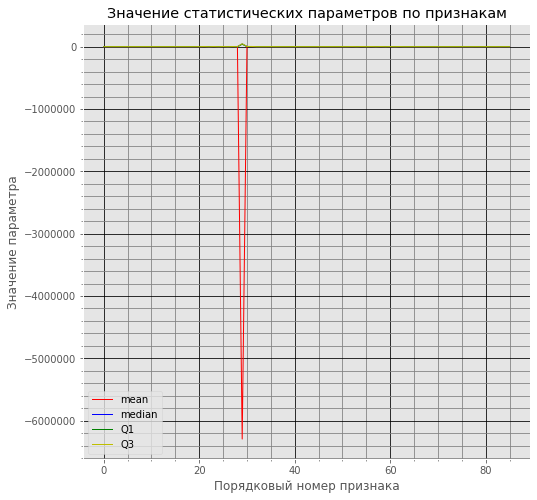

Значительное различие между медианой и средним в колонке "rougher.calculation.sulfate_to_au_concentrate"
Разница составляет 101%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank11_sulfate_to_au_feed"
Разница составляет -26%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.state.floatbank10_a_level"
Разница составляет 23%, возможны выбросы



In [31]:
_tresh = plot_stat_info(df_full, df_full_numeric_cols, diff_treshhold=0.2)

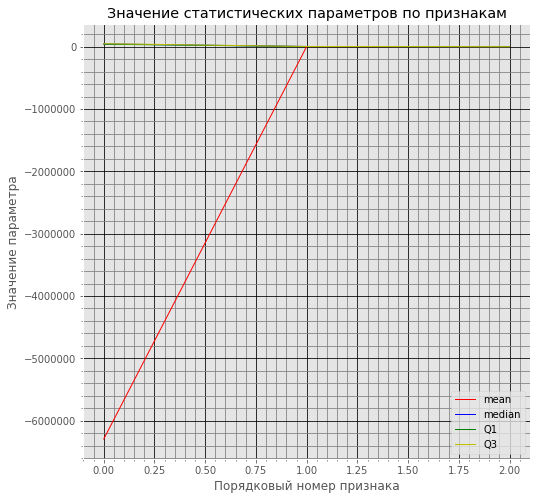

Значительное различие между медианой и средним в колонке "rougher.calculation.sulfate_to_au_concentrate"
Разница составляет 101%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.calculation.floatbank11_sulfate_to_au_feed"
Разница составляет -26%, возможны выбросы

Значительное различие между медианой и средним в колонке "rougher.state.floatbank10_a_level"
Разница составляет 23%, возможны выбросы



['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.state.floatbank10_a_level']

In [32]:
plot_stat_info(df_full, _tresh, diff_treshhold=.2)

Колонки с 0 по 3


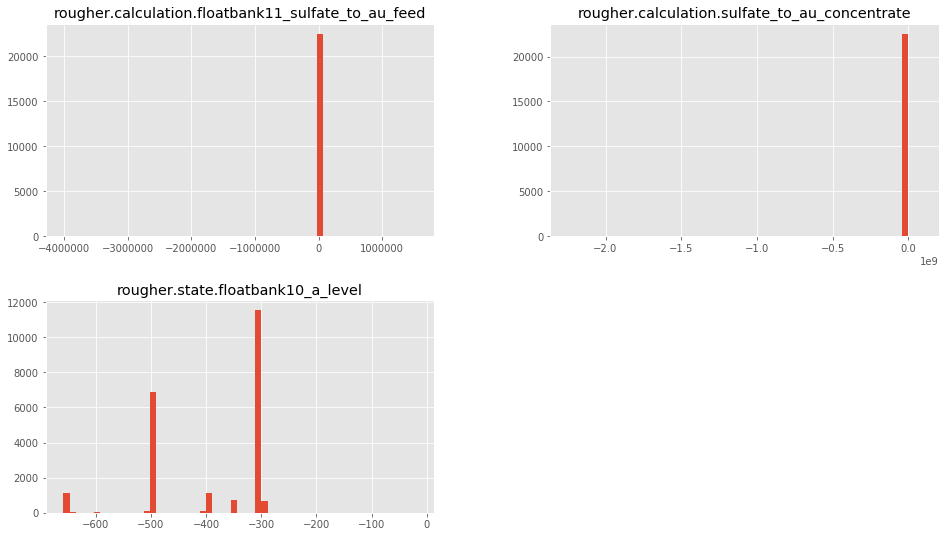

Index(['rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.state.floatbank10_a_level'],
      dtype='object')

In [33]:
hist_bulding(df_full[_tresh])

### Вывод

1. В `df_full` наблюдается пропущенные значения в 85 из 86 колонках, с количеством пропусков от 0,19% до 13,73%
2. Из гистограмм наблюдается:
    + большое количество нулевых значений по отдельным признакам
    + отдельные признаки практически не меняются
    + для отдельных признаков наблюдаются выбросы
3. Определены колонки с отклонениями между медианой и средним больше 20%, построены дистограммы для этих признаков, делая вывод из распределения на гистограммах можно заметить, что величины практически не меняются в наблюдениях, возможно в дальнейшем можно удалить эти признаки из модели (проверим далее в проекте)
4. Имеются объекты, определенные как дубликаты, необходимо проверить

## 1.2. Проверка правильности расчета `rougher.output.recovery`

Вычислим эффективность обогащения для признака `rougher.output.recovery` на обучающей выборке. Найдим MAE между полученными расчётами и значением признака.

Будем использовать формулу для расчета:
![](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

In [34]:
df_train['recovery_compute']  = recovery_compute(
    df_train,
    c='rougher.output.concentrate_au',
    f = 'rougher.input.feed_au',
    t = 'rougher.output.tail_au')

In [35]:
query_notnull_recovery = df_train['rougher.output.recovery'].notnull()

print(mean_absolute_error(df_train.loc[query_notnull_recovery, 'recovery_compute'], 
                    df_train.loc[query_notnull_recovery, 'rougher.output.recovery']))

df_train = df_train.drop(columns=['recovery_compute'], axis=1)

9.444891926100695e-15


### Вывод

1. Разница между существующим `rougher.output.recovery` и расчитаным близка к нулю, следовательно данным можно доверять
2. Для заполнения пропусков можно использовать имеющиеся данные
3. Необходимо обработать пропуски

## 1.3. Проанализируем признаки, отсутствующие в тестовой выборке

In [36]:
missing_features = []
for col in df_train.columns:
    if col not in df_test.columns:
        missing_features.append(col)

In [37]:
missing_features

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

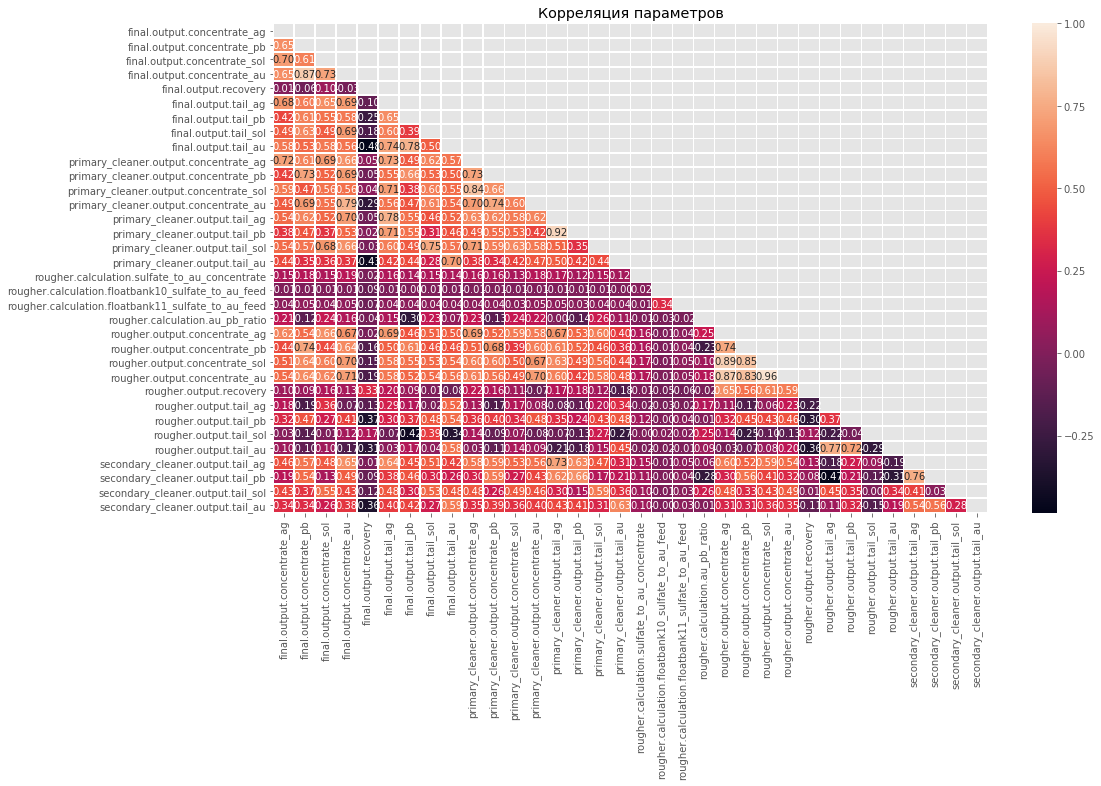

In [38]:
mask = np.zeros_like(df_full[missing_features].corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data=df_full[missing_features].corr(),
    annot=True, fmt='0.2f', linewidths=.8, mask=mask
)
plt.title('Корреляция параметров')
plt.show()

### Вывод

1. В тестовой выборке отсутствуют значения содержащие результаты концентраций иследуемого металла в полученом продукте
2. Наблюдается значительная корреляция между отдельными параметрами, что также подтверждает, что они могут ухудшать модель

Т.к. **отсутствующие признаки не описывают состояние технологического процесса**, а больше относятся к характеристике обрабатываемого сырья, то в дальнейшем удалим эти признаки из тренировочной выборки при обучении модели

## 1.4. Предобработка данных

Заменим пропуски в основном датасете `df_full` и далее восстановим данные в тренировочной и тестовой выборках

Сначала восстановим пропуски в признаках не участвующих в расчете эффективности (потом удалим их), исключив концентрации указанные в пункте выше.
для этого добавим из таблицы `df_full` в таблицу `df_test` целевые признаки, а потом удалим все признаки, которые не содержатся в тестовой выборке

In [39]:
_recovery_target_cols = [
    'rougher.output.recovery',
    'final.output.recovery'
]

_recovery_cols = [
    'rougher.output.concentrate_au',
    'rougher.output.tail_au',
    'final.output.concentrate_au',
    'final.output.tail_au'
    
]
df_test = df_test.join(df_full[_recovery_target_cols], how='left')

cols_for_model = df_test.columns

df_test = df_test.join(df_full[_recovery_cols], how='left')

In [40]:
[_recovery_cols.append(elem) for elem in _recovery_target_cols]

[None, None]

In [41]:
_recovery_cols.append('rougher.input.feed_au')

In [42]:
_recovery_cols

['rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'final.output.concentrate_au',
 'final.output.tail_au',
 'rougher.output.recovery',
 'final.output.recovery',
 'rougher.input.feed_au']

### 1.4.1. Восстановим данные в пропуски в остальных признаках методом `fillna(method = 'ffill')`

Т.к. имеющиеся данные имеют почасовую фиксацию параметров, то примем, что пропуски прификсации тех параметров появились вследствие незначительного изменения или постоянства процесса и для экономии времени не фиксировались.<br/>
Таким образом наилучшим значением для замены пропуска будет значение за предыдущий час

In [43]:
data_full_null_values = null_values_fraction(df_full)

первые 5 строк
rougher.output.recovery               13.73%
rougher.output.tail_ag                12.05%
rougher.output.tail_sol               12.04%
rougher.output.tail_au                12.04%
rougher.input.floatbank11_xanthate     9.94%
dtype: object

последние 5 строк
rougher.calculation.sulfate_to_au_concentrate    0.19%
primary_cleaner.state.floatbank8_d_level         0.19%
primary_cleaner.state.floatbank8_b_level         0.19%
primary_cleaner.state.floatbank8_c_level         0.19%
primary_cleaner.input.feed_size                  0.00%
dtype: object


In [44]:
data_full_null_values = data_full_null_values[(data_full_null_values != '0.00%') == True]

col_for_fill_missing = data_full_null_values.index.drop(labels=_recovery_cols).values

In [45]:
df_full[col_for_fill_missing] = df_full[col_for_fill_missing].fillna(method='ffill')

In [46]:
data_full_null_values = null_values_fraction(df_full)

первые 5 строк
rougher.output.recovery          13.73%
rougher.output.tail_au           12.04%
final.output.recovery             8.64%
rougher.input.feed_au             0.44%
rougher.output.concentrate_au     0.43%
dtype: object

последние 5 строк
rougher.state.floatbank10_d_level    0.00%
rougher.state.floatbank10_e_air      0.00%
rougher.state.floatbank10_e_level    0.00%
rougher.state.floatbank10_f_air      0.00%
final.output.concentrate_ag          0.00%
dtype: object


Пропуски заполнили, не забудем удалить в конце лишнии признаки

### 1.4.2. Восстановим данные в `rougher.output.recovery`

Восстановим используя формулу расчета, где это возможно

In [47]:
_query_not_null = (
    (df_full['rougher.output.concentrate_au'].notnull())
    & (df_full['rougher.input.feed_au'].notnull())
    & (df_full['rougher.output.tail_au'].notnull())
)

_query_recovery_null = df_full['rougher.output.recovery'].isna()

_recovery_cols = [
    'rougher.output.recovery',
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au'
]

df_full.loc[
    _query_recovery_null & _query_not_null, _recovery_cols
].describe()#Есть нулевые значения, проверим

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
count,0.0,382.000000,382.000000,382.000000
mean,NaN,6.326330,5.801159,1.929251
std,NaN,7.023652,4.472005,0.898322
min,NaN,0.000000,0.000000,0.247966
25%,NaN,0.010000,0.010000,1.391482
50%,NaN,4.537944,7.617240,1.824065
75%,NaN,9.228127,9.428414,2.291477
max,NaN,24.470183,12.847390,8.932753


In [48]:
df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.output.concentrate_au'] == 0),
    _recovery_cols   
].describe()

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
count,0.0,39.0,39.0,39.000000
mean,NaN,0.0,0.0,2.229062
std,NaN,0.0,0.0,0.758819
min,NaN,0.0,0.0,1.285754
25%,NaN,0.0,0.0,1.765389
50%,NaN,0.0,0.0,2.104815
75%,NaN,0.0,0.0,2.529303
max,NaN,0.0,0.0,5.834024


По имеющейся инфомации сложно судить о причине нулевых значений, возможно неправильное определение концентрации в исходном сырье и концентрате, также может быть нарушение самого технологического процесса. Т.к. без дополнительных уточнений причина не ясна, то предлагается удалить эти эти пропуски

In [49]:
_index_to_drop = df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.output.concentrate_au'] == 0),
    _recovery_cols   
].index

In [50]:
df_full = df_full.drop(index=_index_to_drop)

In [51]:
df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == 0),
    _recovery_cols   
].describe()

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
count,0.0,48.000000,48.0,48.000000
mean,NaN,16.852971,0.0,2.243827
std,NaN,7.046865,0.0,0.897385
min,NaN,1.336758,0.0,0.734503
25%,NaN,10.854836,0.0,1.760541
50%,NaN,19.628823,0.0,2.133176
75%,NaN,22.309888,0.0,2.676965
max,NaN,24.470183,0.0,5.962158


Возможно при заполнении данных `rougher.input.feed_au` было близко к нулю и его указали как нулевое значение, или записали как нулевое значение в ходе округления

Проверим соответствие других величин при минимальном `rougher.input.feed_au`

In [52]:
_min = df_full.loc[df_full['rougher.input.feed_au'] != 0, 'rougher.input.feed_au'].min()
df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == _min),
    _recovery_cols   
]

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
date,,,,
2018-03-18 11:59:59,NaN,11.245958,0.01,0.436271
2018-03-18 12:59:59,NaN,1.015070,0.01,3.809132
2018-03-18 13:59:59,NaN,17.919109,0.01,3.809132
2018-03-23 09:59:59,NaN,19.521366,0.01,1.446445
2018-03-29 12:59:59,NaN,1.842542,0.01,1.754920
2018-05-01 16:59:59,NaN,17.023279,0.01,1.037259
2018-05-19 08:59:59,NaN,17.940838,0.01,2.449551
2018-05-19 09:59:59,NaN,18.413390,0.01,2.381199
2018-05-19 10:59:59,NaN,17.996343,0.01,2.302712


Проверим равенство значений `rougher.output.concentrate_au`, при `rougher.input.feed_au == 0` и минимальном ненулевом значении

In [53]:
#Сат тест говорит что они могут быть похожи
st.ttest_ind(
    df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == _min),
    'rougher.output.concentrate_au'
    ],
    df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == 0),
    'rougher.output.concentrate_au'   
    ],
    equal_var=False
)

Ttest_indResult(statistic=-1.8559118417269533, pvalue=0.08011541371721427)

И еще `rougher.output.tail_au`

In [54]:
#Сат тест говорит что они тоже могут быть похожи
st.ttest_ind(
    df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == _min),
    'rougher.output.tail_au'
    ],
    df_full.loc[
    _query_recovery_null &
    _query_not_null &
    (df_full['rougher.input.feed_au'] == 0),
    'rougher.output.tail_au'   
    ],
    equal_var=False
)

Ttest_indResult(statistic=-0.4677279295771926, pvalue=0.6455916890805495)

Заменим нули на минимальное значение

In [55]:
df_full['rougher.input.feed_au'] = df_full['rougher.input.feed_au'].replace(0, _min)

Проверим

In [56]:
df_full.loc[
    _query_recovery_null & _query_not_null, _recovery_cols
].describe()

,rougher.output.recovery,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
count,0.0,343.000000,343.000000,343.000000
mean,NaN,7.045650,6.462165,1.895162
std,NaN,7.062177,4.241137,0.907531
min,NaN,0.009975,0.010000,0.247966
25%,NaN,0.628115,1.410150,1.353302
50%,NaN,5.114306,8.059756,1.803354
75%,NaN,9.968674,9.656726,2.251848
max,NaN,24.470183,12.847390,8.932753


Нулевых значений нет, можно заполнить по имеющейся формуле

In [57]:
recovery_for_null_values = recovery_compute(
    df_full.loc[
    _query_recovery_null & _query_not_null, _recovery_cols],
    c='rougher.output.concentrate_au',
    f = 'rougher.input.feed_au',
    t = 'rougher.output.tail_au')

In [58]:
recovery_for_null_values.describe()

count       343.000000
mean      -6132.538803
std       25273.284209
min     -366924.161290
25%         -70.428177
50%          -0.482567
75%         109.520472
max       21320.552413
dtype: float64

Наблюдаются аномальные отрицательные значениия не имеющие смысла<br/>
Проверим только положительные значения

In [59]:
recovery_for_null_values[recovery_for_null_values > 0].describe()

count      148.000000
mean       522.168268
std       2291.291214
min        100.167321
25%        104.731284
50%        112.765570
75%        150.895462
max      21320.552413
dtype: float64

Вероятно, что причиной пропусков в данной колонке послужили ошибки при определении концентраций в ходе технологического процесса, т.к. полученные значения не имеют логического смысла

Предлагается удалить все пропущенные значения

In [60]:
df_full.dropna(subset=['rougher.output.recovery'], inplace=True)

In [61]:
data_full_null_values = null_values_fraction(df_full)

первые 5 строк
final.output.recovery                         0.81%
final.output.concentrate_au                   0.02%
secondary_cleaner.state.floatbank6_a_level    0.00%
rougher.calculation.au_pb_ratio               0.00%
primary_cleaner.state.floatbank8_b_level      0.00%
dtype: object

последние 5 строк
rougher.state.floatbank10_d_air      0.00%
rougher.state.floatbank10_d_level    0.00%
rougher.state.floatbank10_e_air      0.00%
rougher.state.floatbank10_e_level    0.00%
final.output.concentrate_ag          0.00%
dtype: object


### 1.4.3. Восстановим данные в `final.output.recovery`

In [62]:
find_features(df_full, 'final')

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au']

In [63]:
_query_not_null = (
    (df_full['final.output.concentrate_au'].notnull())
    & (df_full['rougher.input.feed_au'].notnull())
    & (df_full['final.output.tail_au'].notnull())
)

_query_recovery_null = df_full['final.output.recovery'].isnull()

_recovery_cols = [
    'final.output.recovery',
    'final.output.concentrate_au',
    'rougher.input.feed_au',
    'final.output.tail_au'
]

df_full.loc[
    _query_recovery_null & _query_not_null, _recovery_cols
].describe()#Есть нулевые значения, проверим

,final.output.recovery,final.output.concentrate_au,rougher.input.feed_au,final.output.tail_au
count,0.0,154.000000,154.000000,154.000000
mean,NaN,15.879997,5.404364,2.140300
std,NaN,19.711253,3.188903,1.981802
min,NaN,0.000000,0.010000,0.000000
25%,NaN,0.000000,2.395448,0.000000
50%,NaN,3.079663,5.597052,1.894301
75%,NaN,39.692206,8.004219,3.512466
max,NaN,53.611374,13.544263,7.826368


Попробуем сразу расчитать, скорее всего природа пропусков схожа с предыдущим признаком

In [64]:
recovery_for_null_values = recovery_compute(
    df_full.loc[
    _query_recovery_null & _query_not_null, _recovery_cols],
    c='final.output.concentrate_au',
    f='rougher.input.feed_au',
    t='final.output.tail_au')

In [65]:
recovery_for_null_values.describe()

count      109.000000
mean      -224.698992
std       1758.296700
min     -15144.851132
25%        -43.627075
50%        -10.730938
75%         -0.339797
max       1824.578217
dtype: float64

In [66]:
recovery_for_null_values[recovery_for_null_values > 0]

date
2016-04-16 05:00:00     368.442973
2016-05-01 02:59:59     115.409303
2016-07-23 12:59:59     140.499506
2016-08-09 02:59:59     119.517663
2016-09-16 13:59:59     534.715514
2016-11-06 14:59:59     116.028477
2016-11-26 20:59:59    1824.578217
2017-05-09 05:59:59     138.000298
2017-08-13 19:59:59     529.115395
2017-10-23 12:59:59     115.689278
2017-11-18 09:59:59     194.825694
2017-12-12 06:59:59     153.304399
2017-12-26 06:59:59     132.962360
2018-04-02 23:59:59     104.072238
2018-06-14 20:59:59     112.906670
2018-07-06 14:59:59     123.364123
dtype: float64

Наблюдается аналогичная ситуация, в связи с этим удалим пропуски

In [67]:
df_full.dropna(axis=0, subset=['final.output.recovery'], inplace=True)

In [68]:
data_full_null_values = null_values_fraction(df_full)

первые 5 строк
secondary_cleaner.state.floatbank6_a_level            0.00%
rougher.calculation.floatbank11_sulfate_to_au_feed    0.00%
primary_cleaner.state.floatbank8_b_air                0.00%
primary_cleaner.state.floatbank8_b_level              0.00%
primary_cleaner.state.floatbank8_c_air                0.00%
dtype: object

последние 5 строк
rougher.state.floatbank10_d_air      0.00%
rougher.state.floatbank10_d_level    0.00%
rougher.state.floatbank10_e_air      0.00%
rougher.state.floatbank10_e_level    0.00%
final.output.concentrate_ag          0.00%
dtype: object


### 1.4.4. Удалим признаки, которые не будем использовать в модели и обновим результаты заполнения пропусков в датасетах

In [69]:

df_train = df_train[cols_for_model.sort_values()]
df_test = df_test[cols_for_model.sort_values()]

In [70]:
index_after_prepare = []
for ind in df_train.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)

In [71]:
df_train = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [72]:
index_after_prepare = []
for ind in df_test.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)
df_test = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [73]:
len(df_train) + len(df_test) == len(df_full)

True

## Вывод

1. В исходных данных наблюдается значительное количество пропусков, как выяснилось в ходе анализа большинство пропусков соответствует признакам содержащим расчет эффективности, при восстановлении пропусков в этих колонках обнаружили не логичные значения признака, всвязи с этим пропуски были удалены - вероятнее всего были допущены ошибки при определении параметров учавствующих в расчете эффективности.
2. Т.к. данные соответствуют почасовой фиксации параметров процесса, то в качестве пропусков было принято использовать значение для предыдущего часа.
3. Из гистограмм наблюдается:
    + большое количество нулевых значений по отдельным признакам
    + отдельные признаки практически не меняются
    + для отдельных признаков наблюдаются выбросы
4. Определены колонки с отклонениями между медианой и средним больше 20%, построены дистограммы для этих признаков, делая вывод из распределения на гистограммах можно заметить, что величины практически не меняются в наблюдениях, возможно в дальнейшем можно удалить эти признаки из модели (проверим далее в проекте)
5. Имеются объекты, определенные как дубликаты, необходимо проверить
6. При пересчете и определении MAE между имеющимся значением эффективности и расчетным отличий не обнаружено
7. Признаки отсутстовавшие в тестовой выборке не описывают технологический процесс получения золота, всвязи с этим было принято решение удалить их из тестовой и обучающих выборках

# 2. Анализ данных

## 2.1. Проверим поведение концентраций в сырье в зависимости от этапа

In [74]:
def hist_box(df, columns):   
    
    
    ticks = [" ".join((columns[i]).split(sep='.')[:2]) for i in range(len(columns))]
    #hist
    bins_number = int(np.ceil(2 * (len(df) ** (1 / 3))))
    
    for cols in columns:
        df[cols].plot(kind='hist', alpha=0.7,
                           bins=bins_number, density=True,
                           grid=True, figsize=(9,6))

    plt.legend(ticks, loc=0)
    plt.title('Распределение концентраций в зависимости от этапа очистки')
    plt.ylabel('Вероятность')
    plt.xlabel('Концентрация')
    plt.show()
    


    #boxplot
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df[columns], orient='h')
    plt.title('Boxplot концентраций')
    plt.xlabel('Концентрация')
    plt.show()


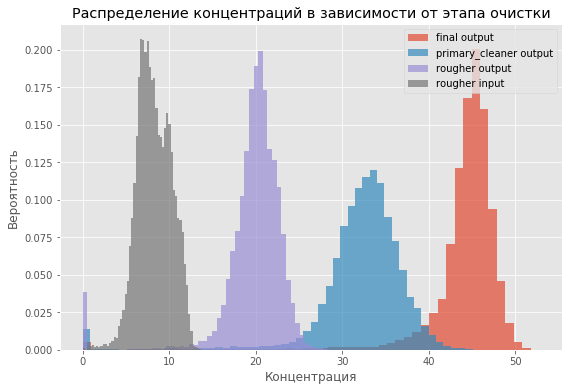

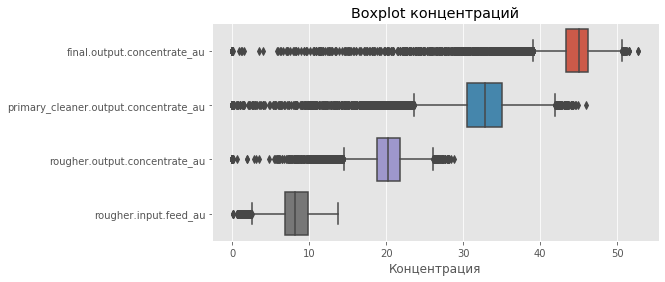

In [75]:
concentrate_au_cols = find_features(df_full, 'concentrate_au')
concentrate_au_cols.append('rougher.input.feed_au')
hist_box(df_full, concentrate_au_cols)

С каждым этапом очистки концентрация золота возрастает

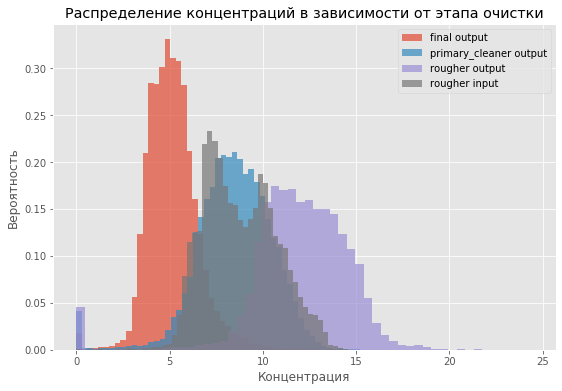

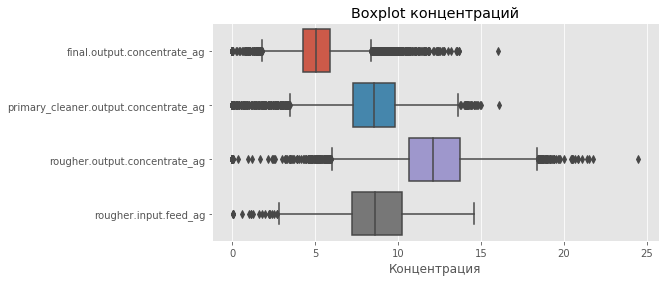

In [76]:
concentrate_ag_cols = find_features(df_full, 'concentrate_ag')
concentrate_ag_cols.append('rougher.input.feed_ag')
hist_box(df_full, concentrate_ag_cols)

Концентрация серебра достигает максимальной концентрации после флотации, далее после каждой из 1-й и 2-ой очистки концентрация снижается

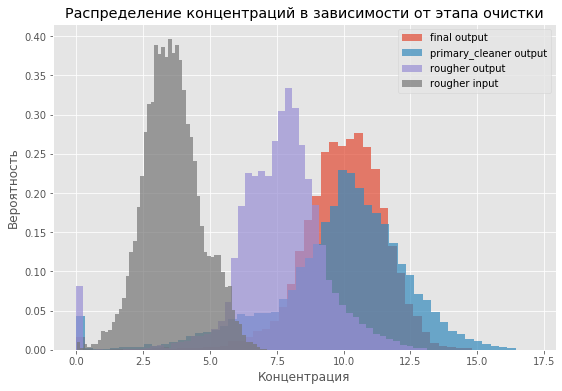

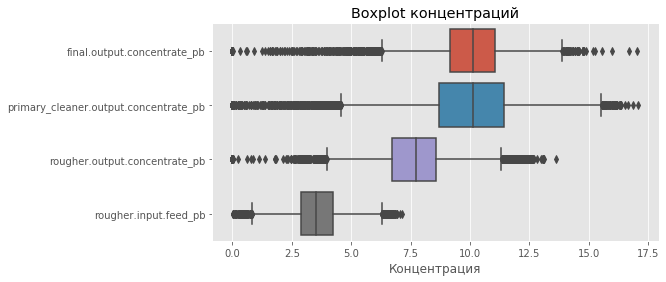

In [77]:
concentrate_pb_cols = find_features(df_full, 'concentrate_pb')
concentrate_pb_cols.append('rougher.input.feed_pb')
hist_box(df_full, concentrate_pb_cols)

Увеличение содержания свинца возрастает после флотации и 1-ой очистки, после 2-го этапа очистки практчески не меняется

### Вывод

1. Концентрация золота увеличивается по мере прохождения сырьем этапов очистки
2. Концентрация серебра достигает максимальной концентрации после флотации, далее после каждой из 1-й и 2-ой очистки концентрация снижается
3. Увеличение содержания свинца возрастает после флотации и 1-ой очистки, после 2-го этапа очистки практчески не меняется
4. В исходном сырье наблюбается 2 пика для Золота и Серебра
5. Наблюдаются нулевые значения концентраций, возможно ошибки измерения, т.к. в исходном сырье такого количества наблюдений с нулевой концентрацией нет, следовательно в технологическом сырье после прохождения этапов содержание наблюдаться дожно, предлагается удалить эти значения тосле проверки сумарной концентрации по этапам

## 2.2. Распределение размеров исходного сырья в тестовой и тренировочной выборках

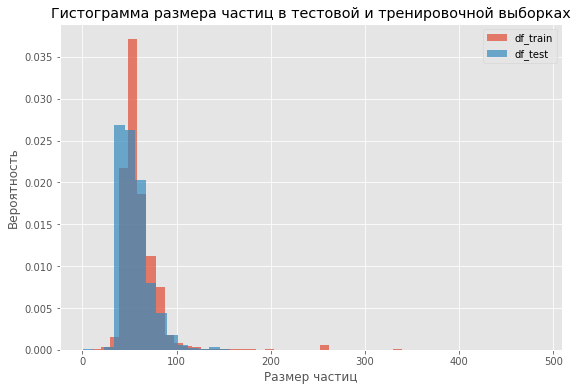

In [78]:
feed_size_cols = find_features(df_full, 'feed_size')
feed_size_cols.remove('primary_cleaner.input.feed_size')
fig, ax = plt.subplots()

for df in [df_train, df_test]:
    bins_number = int(np.ceil(2 * (len(df) ** (1 / 3))))
    df[feed_size_cols].plot(kind='hist', alpha=0.7,
                            bins=bins_number, density=True,
                            grid=True, figsize=(9,6), ax=ax)
plt.legend(['df_train', 'df_test'])
plt.xlabel('Размер частиц')
plt.ylabel('Вероятность')
plt.title('Гистограмма размера частиц в тестовой и тренировочной выборках')
plt.show()

Распределение размеров в выборках схожи, однако наблюдается некоторые выбросы в тренировочной выборке, проверим выбросы и удалим их

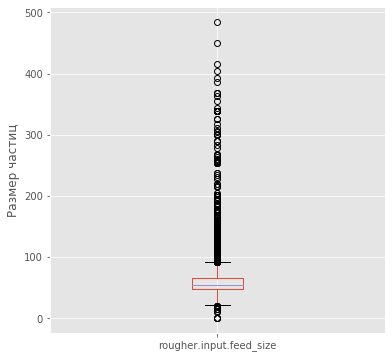

In [79]:
df_full[feed_size_cols].boxplot(figsize=(6, 6))
plt.ylabel('Размер частиц')
plt.show()

Удалим значения которые попали выше 99 персентиля и меньше 1

In [80]:
df_full = df_full.loc[
    df_full['rougher.input.feed_size'] < np.percentile(df_full['rougher.input.feed_size'], 99)
]

In [81]:
df_full = df_full.loc[
    df_full['rougher.input.feed_size'] > np.percentile(df_full['rougher.input.feed_size'], 1)
]

In [82]:
np.percentile(df_full['rougher.input.feed_size'], .0001)

36.24378896627922

Уберем соответствующие объекты и из выборок для модели

In [83]:
index_after_prepare = []
for ind in df_train.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)

In [84]:
df_train = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [85]:
index_after_prepare = []
for ind in df_test.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)
df_test = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [86]:
len(df_train) + len(df_test) == len(df_full)

True

Проверим распределение еще раз

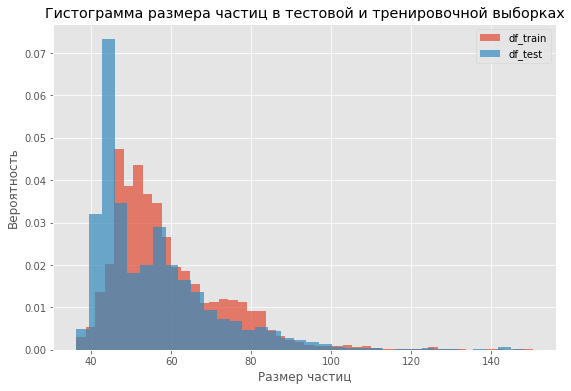

In [87]:
fig, ax = plt.subplots()

for df in [df_train, df_test]:
    bins_number = int(np.ceil(2 * (len(df) ** (1 / 3))))
    df[feed_size_cols].plot(kind='hist', alpha=0.7,
                            bins=bins_number, density=True,
                            grid=True, figsize=(9,6), ax=ax)
plt.legend(['df_train', 'df_test'])
plt.xlabel('Размер частиц')
plt.ylabel('Вероятность')
plt.title('Гистограмма размера частиц в тестовой и тренировочной выборках')
plt.show()

In [88]:
st.ttest_ind(df_train[feed_size_cols], df_test[feed_size_cols], equal_var=False)

Ttest_indResult(statistic=array([14.8257791]), pvalue=array([3.8438964e-49]))

In [89]:
df_train[feed_size_cols].mean()

rougher.input.feed_size    59.123768
dtype: float64

In [90]:
df_test[feed_size_cols].mean()

rougher.input.feed_size    55.552162
dtype: float64

Хоть и небольшая разница наблюдается, как и в распределении, так и по результатам теста, всеже по виду гистограммы можно сделать вывод, что размеры частиц примерно похожи

## 2.3. Исследуйем суммарную концентрацию всех веществ на разных стадиях

In [91]:
cols = [
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb', 
    'rougher.input.feed_sol', 
    'rougher.input.feed_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
    'final.output.concentrate_au'
]

cols_of_sum = [
    'sum_rougher_feed',
    'sum_rougher_concentrate',
    'sum_primary_cleaner_concentrate',
    'sum_final_concentrate'
]


j = 0
for i in range(len(cols_of_sum)):
    df_full[cols_of_sum[i]] = df_full[cols[j : j + 4]].sum(axis=1)
    j += 4

In [92]:
df_full[cols_of_sum].describe()

,sum_rougher_feed,sum_rougher_concentrate,sum_primary_cleaner_concentrate,sum_final_concentrate
count,19051.000000,19051.000000,19051.000000,19051.000000
mean,57.426733,68.153020,60.798884,68.744886
std,7.130713,12.542839,9.958498,7.152756
min,0.040000,0.000000,0.000000,0.000000
25%,53.671680,66.008721,58.967563,67.964133
50%,57.643333,70.174810,62.511103,69.631375
75%,62.024197,74.362167,65.675982,71.384255
max,76.978947,87.918479,80.749343,80.210644


In [93]:
tail_concentrate = find_features(df_full, 'tail')

In [94]:
tail_sum_cols = [
    'sum_final_tail',
    'sum_primary_cleaner_tail',
    'sum_rougher_tail',
    'sum_secondary_cleaner_tail'    
]

j = 0
for i in range(len(tail_sum_cols)):
    df_full[tail_sum_cols[i]] = df_full[tail_concentrate[j : j + 4]].sum(axis=1)
    j += 4

In [95]:
df_full[tail_sum_cols].describe()

,sum_final_tail,sum_primary_cleaner_tail,sum_rougher_tail,sum_secondary_cleaner_tail
count,19051.000000,19051.000000,19051.000000,19051.000000
mean,26.054509,31.481311,26.124797,31.369616
std,4.577679,5.570825,3.487361,8.181480
min,0.000000,0.000000,16.006292,0.000000
25%,23.618482,28.338328,23.980316,29.862454
50%,25.932826,31.276945,26.030430,32.291233
75%,28.566604,34.692743,28.179539,35.097949
max,43.270605,57.285225,76.431660,58.453347


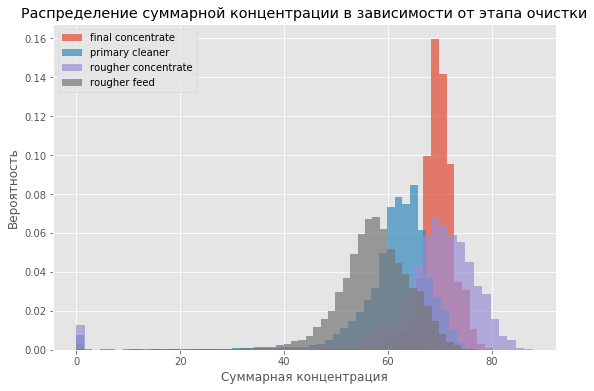

In [96]:
bins_number = int(np.ceil(2 * (len(df_full) ** (1 / 3))))
my_ticks = [" ".join((cols_of_sum[-i]).split(sep='_')[1:3]) for i in range(1, len(cols_of_sum) + 1)]

for i in range(1, len(cols_of_sum) + 1):
    df_full[cols_of_sum[-i]].hist(bins=bins_number, density=True,
                      grid=True, figsize=(9,6),
                      alpha=.7
                     )

plt.legend(my_ticks, loc=0)
plt.title('Распределение суммарной концентрации в зависимости от этапа очистки')
plt.ylabel('Вероятность')
plt.xlabel('Суммарная концентрация')
plt.show()


Нулевая концентрация - возможно все все ушло в хвосты

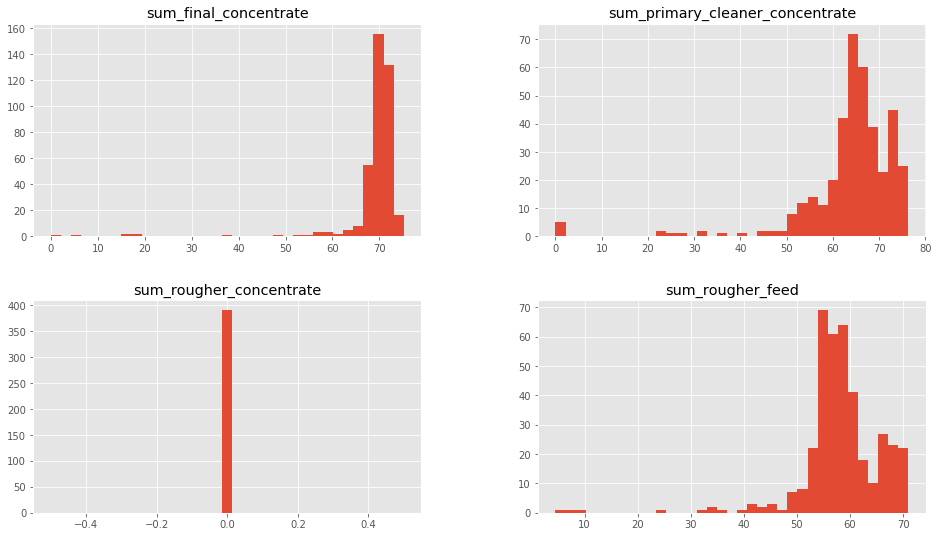

In [97]:
df_full.loc[(df_full['sum_rougher_concentrate'] == 0), cols_of_sum].hist(bins=35)
plt.show()

Как видно из гистограмм при получении нулевого значения концентрации после флотации продолжали наблюдать ненулевые значения понцентрации на последующих этапах, чего быть не может. Наблюдается только 1 случай нулевых значений концентраций в финальном продукте, проверим их

In [98]:
df_full.loc[(df_full['sum_rougher_concentrate'] == 0) &
            (df_full['sum_final_concentrate'] == 0), cols_of_sum]

,sum_rougher_feed,sum_rougher_concentrate,sum_primary_cleaner_concentrate,sum_final_concentrate
date,,,,
2016-09-02 06:59:59,4.501868,0.0,0.0,0.0


в этих случаях поже действительно могло быть нарушение процесса и весь продукт уходил в хвосты, проверим их

In [99]:
df_full.loc[(df_full['sum_rougher_concentrate'] == 0) &
            (df_full['sum_final_concentrate'] == 0), tail_sum_cols]

,sum_final_tail,sum_primary_cleaner_tail,sum_rougher_tail,sum_secondary_cleaner_tail
date,,,,
2016-09-02 06:59:59,2.630225,0.0,25.640934,30.220741


В хвостовом продукте наблюдается наличие металлов, даже при условии, что он не наблюдался в исходном сырье, что также не соответсвует лоигческому объяснению.

Как уже описывалось в п. 2.1. наблюдается наличие нулевых значений концентрации после стадий очистки, при этом в исходном сырье нулевых значений не наблюдается и в хвостовых отходах продолжают фиксировать наличие металлов.
Скорее всего были допущены ошибки при заполнении или при определении значений

Предлагается удалить нулевые значения т.к. их наличие логически не обосновывается  

In [100]:
df_full.loc[df_full['sum_final_concentrate'] < 1, cols_of_sum] #Тоже удалим

,sum_rougher_feed,sum_rougher_concentrate,sum_primary_cleaner_concentrate,sum_final_concentrate
date,,,,
2016-02-13 11:00:00,46.703740,56.574778,53.725613,0.00
2016-03-11 10:00:00,53.368945,61.681632,61.254172,0.00
2016-03-11 11:00:00,51.963364,60.214950,60.410868,0.00
2016-03-11 12:00:00,48.892687,58.592426,60.154484,0.00
2016-03-11 13:00:00,49.265736,58.363177,59.909714,0.00
...,...,...,...,...
2017-12-26 19:59:59,70.195851,74.356346,63.650614,0.00
2017-12-26 20:59:59,69.677719,69.414486,66.086057,0.00
2018-01-15 20:59:59,52.381155,41.632238,3.360363,0.00


In [101]:
for col in cols_of_sum:
    df_full = df_full.loc[df_full[col] > .04]

In [102]:
df_full[cols_of_sum].describe()

,sum_rougher_feed,sum_rougher_concentrate,sum_primary_cleaner_concentrate,sum_final_concentrate
count,18366.000000,18366.000000,18366.000000,18366.000000
mean,57.453268,69.631111,61.472009,69.073291
std,7.004479,7.681418,7.479161,5.422880
min,8.072476,2.016647,0.113023,1.976540
25%,53.653556,66.392001,59.120571,67.972819
50%,57.650400,70.341656,62.536349,69.642846
75%,62.027683,74.472034,65.666165,71.401944
max,76.978947,87.273435,80.749343,80.210644


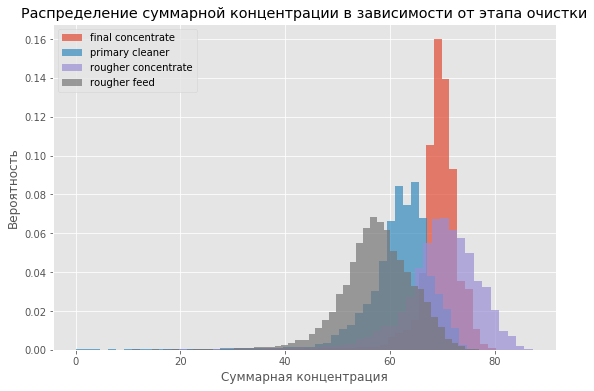

In [103]:
bins_number = int(np.ceil(2 * (len(df_full) ** (1 / 3))))
my_ticks = [" ".join((cols_of_sum[-i]).split(sep='_')[1:3]) for i in range(1, len(cols_of_sum) + 1)]

for i in range(1, len(cols_of_sum) + 1):
    df_full[cols_of_sum[-i]].hist(bins=bins_number, density=True,
                      grid=True, figsize=(9,6),
                      alpha=.7
                     )

plt.legend(my_ticks, loc=0)
plt.title('Распределение суммарной концентрации в зависимости от этапа очистки')
plt.ylabel('Вероятность')
plt.xlabel('Суммарная концентрация')
plt.show()


Уберем соответствующие объекты и из выборок для модели

In [104]:
index_after_prepare = []
for ind in df_train.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)

In [105]:
df_train = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [106]:
index_after_prepare = []
for ind in df_test.index:
    if ind in df_full.index:
        index_after_prepare.append(ind)
df_test = df_full.loc[index_after_prepare, cols_for_model.sort_values()]

In [107]:
len(df_train) + len(df_test) == len(df_full)

True

### Вывод:

1. Обнаружены нулевые значения концентраций, при этом в исходном сырье содержание металлов наблюдалось
2. У объектов с нулевым значением концентраций далее по стадиям обработки наблюдалось "появление" концентрации и также наличие содержание металлов в хвостовом продукте, что логически кроме ка ошибкой не объясняется.
3. Нулевые значения удалили

## 2.4. Проверим важность признаков

### 2.4.1. Наличие констант или около констант

In [108]:
df_train.describe().T.sort_values(by='std')['std'].head(10)

primary_cleaner.input.xanthate        0.376006
primary_cleaner.input.feed_size       0.608640
rougher.input.floatbank10_xanthate    1.060750
rougher.input.feed_pb                 1.086968
rougher.input.floatbank11_xanthate    1.395625
rougher.input.feed_ag                 1.885016
rougher.input.feed_au                 1.889607
rougher.input.floatbank10_sulfate     3.182193
primary_cleaner.input.depressant      3.321416
rougher.input.floatbank11_sulfate     3.651194
Name: std, dtype: float64

Не обнаружили

### 2.4.1. Feature impotantce

Разобьем выборки на обучающие признаки и целевой

In [109]:
y_train_roug = df_train['rougher.output.recovery']
y_train_fin = df_train['final.output.recovery']
X_train = df_train.drop(columns=['rougher.output.recovery', 'final.output.recovery'])

In [110]:
y_test_roug = df_test['rougher.output.recovery']
y_test_fin = df_test['final.output.recovery']
X_test = df_test.drop(columns=['rougher.output.recovery', 'final.output.recovery'])

Обучим модель

In [111]:
model = DecisionTreeRegressor(random_state=42)

In [112]:
%%time
df_imp_feats_roug, df_imp_feat_result = cols_feat_importances(model, X_train, y_train_roug)


Лучший результат при 36 признаках, MAE = 2.65273, sMAPE = 3.34000
CPU times: user 28.4 s, sys: 55.1 ms, total: 28.4 s
Wall time: 29.4 s


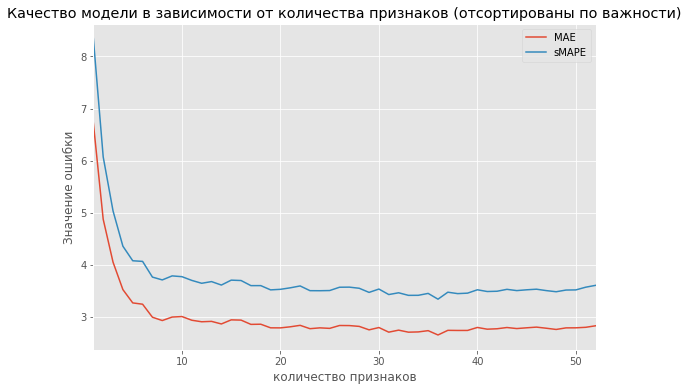

In [113]:
df_imp_feat_result.plot(grid=True, figsize=(9,6))
plt.xlabel('количество признаков')
plt.ylabel('Значение ошибки')
plt.title('Качество модели в зависимости от количества признаков (отсортированы по важности)')

plt.show()

In [114]:
df_imp_feat_result.sort_values(by='sMAPE').head()

,MAE,sMAPE
число_признаков,,
36,2.652729,3.340000
33,2.706352,3.413226
34,2.711404,3.414117
31,2.706772,3.428639
38,2.739422,3.446512


Наилучший результат получен при 27 наиболее важных признаках, для построения модели будем использовать их

In [115]:
cols_for_roug_model = df_imp_feats_roug [:36].index

Аналогично выполним для эффективности финального этапа

In [116]:
%%time
df_imp_feats_fin, df_imp_feat_fin_result = cols_feat_importances(model, X_train, y_train_fin)


Лучший результат при 27 признаках, MAE = 4.63596, sMAPE = 7.32267
CPU times: user 32 s, sys: 55.4 ms, total: 32 s
Wall time: 32.7 s


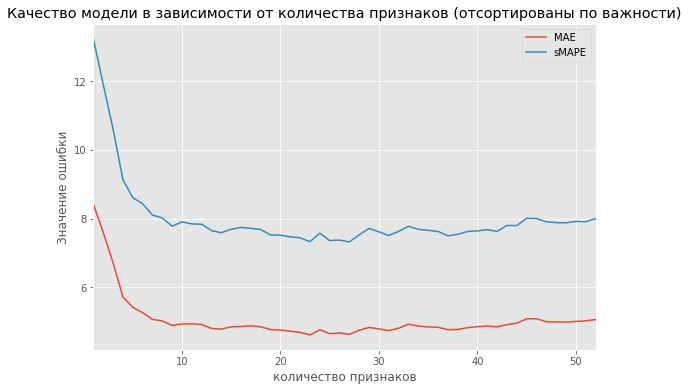

In [117]:
df_imp_feat_fin_result.plot(grid=True, figsize=(9,6))
plt.xlabel('количество признаков')
plt.ylabel('Значение ошибки')
plt.title('Качество модели в зависимости от количества признаков (отсортированы по важности)')

plt.show()

In [118]:
df_imp_feat_fin_result.sort_values(by='sMAPE').head()

,MAE,sMAPE
число_признаков,,
27,4.635960,7.322673
23,4.615954,7.328599
25,4.653266,7.361584
26,4.674856,7.375507
22,4.694108,7.443059


In [119]:
cols_for_fin_model = df_imp_feats_fin[:27].index

## Вывод

1. Проанализировали величину концентрации золота в зависимости от стадии обработки:
    1. Концентрация золота увеличивается по мере прохождения сырьем этапов очистки
    2. Концентрация серебра достигает максимальной концентрации после флотации, далее после каждой из 1-й и 2-ой очистки концентрация снижается
    3. Увеличение содержания свинца возрастает после флотации и 1-ой очистки, после 2-го этапа очистки практчески не меняется
    4. В исходном сырье наблюбается 2 пика для Золота и Серебра
    5. Наблюдаются нулевые значения концентраций, возможно ошибки измерения, т.к. в исходном сырье такого количества наблюдений с нулевой концентрацией нет, следовательно в технологическом сырье после прохождения этапов содержание наблюдаться дожно, предлагается удалить эти значения тосле проверки сумарной концентрации по этапам
    

2. Проверили распределение размера частиц в тестовой и тренировойной выборках:
    1. Распределение размеров в выборках схожи, однако наблюдается некоторые выбросы в тренировочной выборке, удалили крайние значения соответствующие 1-му и 99-му процентилям



3. Проанализировали суммарную величину концентраций металлов в зависимости от стадии обработки:
    1. Обнаружены нулевые значения концентраций, при этом в исходном сырье содержание металлов наблюдалось
    2. У объектов с нулевым значением концентраций далее по стадиям обработки наблюдалось "появление" концентрации и также наличие содержание металлов в хвостовом продукте, что логически кроме ка ошибкой не объясняется.
    3. Нулевые значения удалили


4. Применили медот RFE для поиска оптимального набора признаков для моделей:
    1. Для предсказания величины `'rougher.output.recovery'` наилучший результат получен при 27 наиболее важных признаках<br/>Набор сохранили в переменной `cols_for_roug_model`.<br/>
    2. Для предсказания величины `'final.output.recovery'` наилучший результат получен при 15 наиболее важных признаках.<br/>Набор сохранили в переменной `cols_for_fin_model`

    


# 3. Модель

Качество моделей будем проверять при помощи кросс-валидации, для этого создадим метрику оценки качества

In [120]:
sMAPE_score = make_scorer(sMAPE_compute, greater_is_better=False)

## 3.1. `'final.output.recovery'`

In [121]:
KNR_param_fin = {
    'n_neighbors' : range(317, 320), #Проверял range(5, 300)
    'weights'     : ['distance'], #Проверял [distance', 'uniform']
    'leaf_size'   : [20] #Проверял range(20, 60)
}


KNR_fin = GridSearchCV(KNeighborsRegressor(),
                   param_grid=KNR_param_fin,
                   scoring=sMAPE_score,
                   cv=5)

In [122]:
X_train_stand_fin, X_test_stand_fin = standardization_sampels(X_train, X_test, cols_for_fin_model)

In [123]:
KNR_fin.fit(X_train_stand_fin, y_train_fin)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [20], 'n_neighbors': range(317, 320),
                         'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(sMAPE_compute, greater_is_better=False),
             verbose=0)

In [124]:
KNR_fin.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=319, p=2,
                    weights='distance')

In [125]:
KNR_fin.best_score_

-8.805105564369018

In [126]:
pred_fin = KNR_fin.predict(X_test_stand_fin)

In [127]:
sMAPE_compute(y_test_fin, pred_fin)

7.268308926039721

Проверим на вменяемость

In [128]:
sMAPE_sanity_check(y_test_fin, y_train_fin)

8.459492511072742

Модель значительно качественней случайной модели

Проверим с другими моделями

In [129]:
rfr_fin = RandomForestRegressor(random_state=42)

In [130]:
np.mean(cross_val_score(rfr_fin, X_train_stand_fin, y_train_fin, scoring=sMAPE_score, cv=5))

-10.278039686670057

In [131]:
np.mean(cross_val_score(DecisionTreeRegressor(max_depth=6, random_state=42), 
                        X_train_stand_fin, y_train_fin, scoring=sMAPE_score, cv=5))

-10.188813712701052

In [132]:
np.mean(cross_val_score(LinearRegression(), 
                        X_train_stand_fin, y_train_fin, scoring=sMAPE_score, cv=5))

-9.940171462731522

Модель `KNR_fin` показала лучший результ -8.80

## 3.2. `'rough.output.recovery'`

In [133]:
X_train_stand_roug, X_test_stand_roug = standardization_sampels(X_train, X_test, cols_for_roug_model)

In [134]:
KNR_param = {
    'n_neighbors' : range(264,268), #Проверял range(5, 300)
    'weights'     : ['distance'], #Проверял [distance', ‘uniform’]
    'leaf_size'   : [20] #Проверял range(20, 60)
}


KNR_roug = GridSearchCV(KNeighborsRegressor(),
                   param_grid=KNR_param,
                   scoring=sMAPE_score,
                   cv=5)

In [135]:
KNR_roug.fit(X_train_stand_roug, y_train_roug)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [20], 'n_neighbors': range(264, 268),
                         'weights': ['distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(sMAPE_compute, greater_is_better=False),
             verbose=0)

In [136]:
KNR_roug.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=267, p=2,
                    weights='distance')

In [137]:
KNR_roug.best_score_

-6.085853223178366

Проверим на тестовой выборке:

In [138]:
pred_roug = KNR_roug.predict(X_test_stand_roug)

In [139]:
sMAPE_compute(y_test_roug, pred_roug)

4.108891873509285

Проверим на вменяемость

In [140]:
sMAPE_sanity_check(y_test_roug, y_train_roug)

5.242102189473479

Модель значительно качественней случайной модели

Проверим с другими моделями

In [141]:
rfr_roug = RandomForestRegressor(random_state=42)

In [142]:
np.mean(cross_val_score(rfr_roug, X_train_stand_roug, y_train_roug, scoring=sMAPE_score))

-8.203390536229133

In [143]:
np.mean(cross_val_score(DecisionTreeRegressor(max_depth=6, random_state=42), 
                        X_train_stand_roug, y_train_roug, scoring=sMAPE_score, cv=5))

-7.1649621965429535

In [144]:
np.mean(cross_val_score(LinearRegression(), 
                        X_train_stand_roug, y_train_roug, scoring=sMAPE_score, cv=5))

-6.743593991574724

Модель `KNR_roug` показала лучший результ -6.08

## 3.3. Общий Итог

Метрика sMAPE моделей KNR_roug и KNR_fin

In [145]:
sMAPE_roug = sMAPE_compute(y_test_roug, pred_roug)

sMAPE_fin = sMAPE_compute(y_test_fin, pred_fin)

sMAPE_KNR = .25 * sMAPE_roug + .75 * sMAPE_fin

print('Метрика sMAPE полученых моделей : ', sMAPE_KNR)

Метрика sMAPE полученых моделей :  6.478454662907112


Метрика sMAPE случайной модели

In [146]:
sMAPE_roug = sMAPE_sanity_check(y_test_roug, y_train_roug)

sMAPE_fin = sMAPE_sanity_check(y_test_fin, y_train_fin)

sMAPE = .25 * sMAPE_roug + .75 * sMAPE_fin

print('Метрика sMAPE случайной модели : ', sMAPE)

Метрика sMAPE случайной модели :  7.655144930672926


## Вывод

1. На основе выбраных признаков получили модели для предсказания каждого из целевого признака
2. Модели показывают на тестовой выборке лучший результат по сравнению со случайной моделью

# Общий вывод

1. Подготовка исходных данных
    1. В исходных данных наблюдается значительное количество пропусков, как выяснилось в ходе анализа большинство пропусков соответствует признакам содержащим расчет эффективности, при восстановлении пропусков в этих колонках обнаружили не логичные значения признака, всвязи с этим пропуски были удалены - вероятнее всего были допущены ошибки при определении параметров учавствующих в расчете эффективности.
    2. Т.к. данные соответствуют почасовой фиксации параметров процесса, то в качестве пропусков было принято использовать значение для предыдущего часа.
    3. Из гистограмм наблюдается:
        + большое количество нулевых значений по отдельным признакам
        + отдельные признаки практически не меняются
        + для отдельных признаков наблюдаются выбросы
    4. Определены колонки с отклонениями между медианой и средним больше 20%, построены дистограммы для этих признаков, делая вывод из распределения на гистограммах можно заметить, что величины практически не меняются в наблюдениях, возможно в дальнейшем можно удалить эти признаки из модели (проверим далее в проекте)
    5. Имеются объекты, определенные как дубликаты, необходимо проверить
    6. При пересчете и определении MAE между имеющимся значением эффективности и расчетным отличий не обнаружено
    7. Признаки отсутстовавшие в тестовой выборке не описывают технологический процесс получения золота, всвязи с этим было принято решение удалить их из тестовой и обучающих выборках
    
    
    
2. Анализ исходных данных

    1. Проанализировали величину концентрации золота в зависимости от стадии обработки:
        1. Концентрация золота увеличивается по мере прохождения сырьем этапов очистки
        2. Концентрация серебра достигает максимальной концентрации после флотации, далее после каждой из 1-й и 2-ой очистки концентрация снижается
        3. Увеличение содержания свинца возрастает после флотации и 1-ой очистки, после 2-го этапа очистки практчески не меняется
        4. В исходном сырье наблюбается 2 пика для Золота и Серебра
        5. Наблюдаются нулевые значения концентраций, возможно ошибки измерения, т.к. в исходном сырье такого количества наблюдений с нулевой концентрацией нет, следовательно в технологическом сырье после прохождения этапов содержание наблюдаться дожно, предлагается удалить эти значения тосле проверки сумарной концентрации по этапам

    2. Проверили распределение размера частиц в тестовой и тренировойной выборках:
        1. Распределение размеров в выборках схожи, однако наблюдается некоторые выбросы в тренировочной выборке, удалили крайние значения соответствующие 1-му и 99-му процентилям

    3. Проанализировали суммарную величину концентраций металлов в зависимости от стадии обработки:
        1. Обнаружены нулевые значения концентраций, при этом в исходном сырье содержание металлов наблюдалось
        2. У объектов с нулевым значением концентраций далее по стадиям обработки наблюдалось "появление" концентрации и также наличие содержание металлов в хвостовом продукте, что логически кроме ка ошибкой не объясняется.
        3. Нулевые значения удалили

    4. Применили медот RFE для поиска оптимального набора признаков для моделей:
        1. Для предсказания величины `'rougher.output.recovery'` наилучший результат получен при 27 наиболее важных признаках<br/>Набор сохранили в переменной `cols_for_roug_model`.<br/>
        2. Для предсказания величины `'final.output.recovery'` наилучший результат получен при 15 наиболее важных признаках.<br/>Набор сохранили в переменной `cols_for_fin_model`

3. Построение модели:
    1. Построили 2 модели для определения каждого из целевых признаков
    2. Модели прошли проверку на вменяемость
    3. итоговое значение sMAPE составило 6.4784, что является лучшим результатом по сравнению со случайной моделью с результатом 7.6551
    
